# Предсказание стоимости автомобиля на вторичном рынке

**Описание задачи**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

**Описание данных**

 - *Date*: Год выпуска автомобиля.
 - *Make*: Марка автомобиля.
 - *Model*: издание автомобиля определенной марки.
 - *Trim*: Уровни отделки салона автомобиля — это просто разные версии модели.
 - *Body*: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
 - *Transmission*: механизм, который передает мощность от двигателя к колесам.
 - *VIN*: идентификационный номер транспортного средства.
 - *State*: состояние, в котором автомобиль выставлен на аукцион.
 - *Condition*: Состояние автомобилей на момент аукциона.
 - *Odometer*: расстояние, пройденное автомобилем с момента выпуска.
 - *Color*: Цвет кузова автомобиля.
 - *Interior*: Цвет салона автомобиля.
 - *Seller*: Продавец автомобиля, автосалоны.
 - *sellingprice*: цена, по которой автомобиль был продан на аукционе.
 - *saledate*: Дата продажи автомобиля.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from vininfo import Vin
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from catboost import CatBoostRegressor, Pool

Загрузим и изучим данные.

In [2]:
df = pd.read_csv('C:/Users/User/Desktop/used-cars-price-prediction-22ds/train.csv', parse_dates= ['saledate'])
test = pd.read_csv('C:/Users/User/Desktop/used-cars-price-prediction-22ds/test.csv', parse_dates= ['saledate'])
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02 02:30:00+07:00
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25 02:00:00+08:00
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10 02:30:00+07:00
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17 03:00:00+07:00
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03 04:00:00+08:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [4]:
print('Количество дубликатов до обработки:', df.duplicated().sum()) #проверим на наличие дубликатов
df = df.drop_duplicates() #удалим дубликаты
print('Количество дубликатов после обработки:', df.duplicated().sum())

Количество дубликатов до обработки: 0
Количество дубликатов после обработки: 0


Разнесем дополнительную информацию, которую мы можем получить из vin номера.

In [5]:
Vin.__dict__

mappingproxy({'__module__': 'vininfo.toolbox',
              '__doc__': 'Offers basic VIN data extraction facilities.',
              'annotate_titles': {'manufacturer': 'Manufacturer',
               'region': 'Region',
               'country': 'Country',
               'years': 'Years'},
              '__init__': <function vininfo.toolbox.Vin.__init__(self, num: str)>,
              '__str__': <function vininfo.toolbox.Vin.__str__(self)>,
              'validate': <classmethod(<function Vin.validate at 0x0000014F959F9C60>)>,
              'verify_checksum': <function vininfo.toolbox.Vin.verify_checksum(self, *, check_year: bool = True) -> bool>,
              'wmi': <property at 0x14f959db330>,
              'brand': <property at 0x14f959dbab0>,
              'manufacturer': <property at 0x14f95a222f0>,
              'manufacturer_is_small': <property at 0x14f95a222a0>,
              'vds': <property at 0x14f95a22340>,
              'vis': <property at 0x14f95a22390>,
              

Вторая часть VIN-кода — это VDS. Она состоит из шести символов, которые в общем VIN-коде располагаются с 4 по 9 позицию. Данная группа символов указывает, какая конкретно модель у автомобиля. VDS, согласно принятым правилам, состоит из 6 символов. Если производителю автомобиля не требуется 6 символов для обозначения информации об автомобиле, он имеет право заполнить оставшиеся позиции нулями. Первые три цифры в коде VDS указывают на тип кузова автомобиля, установленный двигатель и модель. Следующие символы обозначают другую информацию, которую автопроизводитель посчитал необходимой заложить в VIN-код. Чаще всего это серия автомобиля, максимальная масса, тип шасси, тип трансмиссии, тип тормозной системы и так далее. У каждого производителя свои VDS-коды. Чтобы узнать, какая информация заложена в конкретном коде, нужно ознакомиться со сведениями для конкретного автопроизводителя.

In [6]:
for frame in [df, test]:
    frame['manufacturer'] = frame['vin'].apply(lambda x: Vin(x).manufacturer)
    frame['country'] = frame['vin'].apply(lambda x: Vin(x).country)
    frame['vds'] = frame['vin'].apply(lambda x: Vin(x).vds)
    frame['vis'] = frame['vin'].apply(lambda x: Vin(x).vis[:2])

## Обработка и анализ категориальных данных

Сперва поработаем с категориальными данными.

In [7]:
categorial_columns = df.select_dtypes(include=['object']).columns
categorial_columns

Index(['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'color', 'interior', 'seller', 'saledate', 'manufacturer', 'country',
       'vds', 'vis'],
      dtype='object')

In [8]:
def show_base_info_category_columns(df, column):

    df_pr = df[column].value_counts(normalize=True).to_frame()
    plt.figure(figsize=(22, 7))

    plt.subplot(1, 2, 1)
    sns.lineplot(df_pr, color = 'darkcyan') 
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
    sns.lineplot(df_pr, x=df_pr.index, y=0.01, style=True, dashes=[(3,3)], color = 'tan')
    plt.xticks(rotation=90)
    plt.ylabel('Share')
    plt.xlabel('Values in category')
    plt.title(f'Category structure {column}')
    plt.legend(['count', 'threshold'])

    plt.subplot(1, 2, 2)
    sns.histplot(x=df[column], color='cornflowerblue')
    
    plt.xticks(rotation=90)
    plt.xlabel('Values in category')
    plt.title(f'Count values in category {column}')
    plt.show()

Посмотрим пропуски по категориальным данным. Часть из них можно заполнить по vds номеру. Воспользуемся этой возможностью.

In [9]:
df[categorial_columns].isna().sum()

make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
color             586
interior          586
seller              0
saledate            0
manufacturer        0
country             0
vds                 0
vis                 0
dtype: int64

Для начала нам необходимо получить все уникальные vds номера и разнести по ним информацию о модели, трансмиссии, серии и кузове исходя из тех данных, которые уже есть в обучающей выборке. По остальным проставим значение other.

In [10]:
for frame in [df, test]:
    frame['make'] = frame['manufacturer'].apply(lambda x: x.split()[0])
    for column in ['model', 'trim', 'body']:
        frame[column] = frame[column].str.lower()

In [11]:
print('Количество уникальных vds:', len(df['vds'].unique()))

vds_ = df.loc[(df['model'].notna())&(df['body'].notna())&(df['transmission'].notna())&(df['trim'].notna())]\
                [['make', 'model', 'trim', 'body', 'transmission', 'vds']]
vds_ = vds_.drop_duplicates(subset=['vds'])
vds_ = vds_.rename(columns = {'model':'model_y', 'trim':'trim_y', 'body':'body_y', 'transmission':'transmission_y'})

Количество уникальных vds: 61048


Пропуски заменим следующим образом - если в склеенной таблице с vds присуствует расшифровка указания серии, модели и пр. показателей, заполним этой информацией пустоты, иначе - other.

In [12]:
df = df.merge(vds_[['model_y', 'trim_y', 'body_y', 'transmission_y', 'vds']], on = 'vds', how='left')
for column in ['body', 'transmission', 'trim', 'model']:
    col = column+'_y'
    df[column] = np.where((df[column].isna())&(df[col].notna()), df[col], \
                                 np.where(df[column].notna(), df[column], 'other'))
    
test = test.merge(vds_[['model_y', 'trim_y', 'body_y', 'transmission_y', 'vds']], on = 'vds', how='left')
for column in ['body', 'transmission', 'trim', 'model']:
    col = column+'_y'
    test[column] = np.where((test[column].isna())&(test[col].notna()), test[col], \
                                 np.where(test[column].notna(), test[column], 'other'))

Отлично, теперь когда пропуски заполнены, можно отсечь значения категорий, доля которых менее одного 1% в обучающей выборке (для них поставим значение other).
Пройдемся по всем категориям с большим уникальных значений.

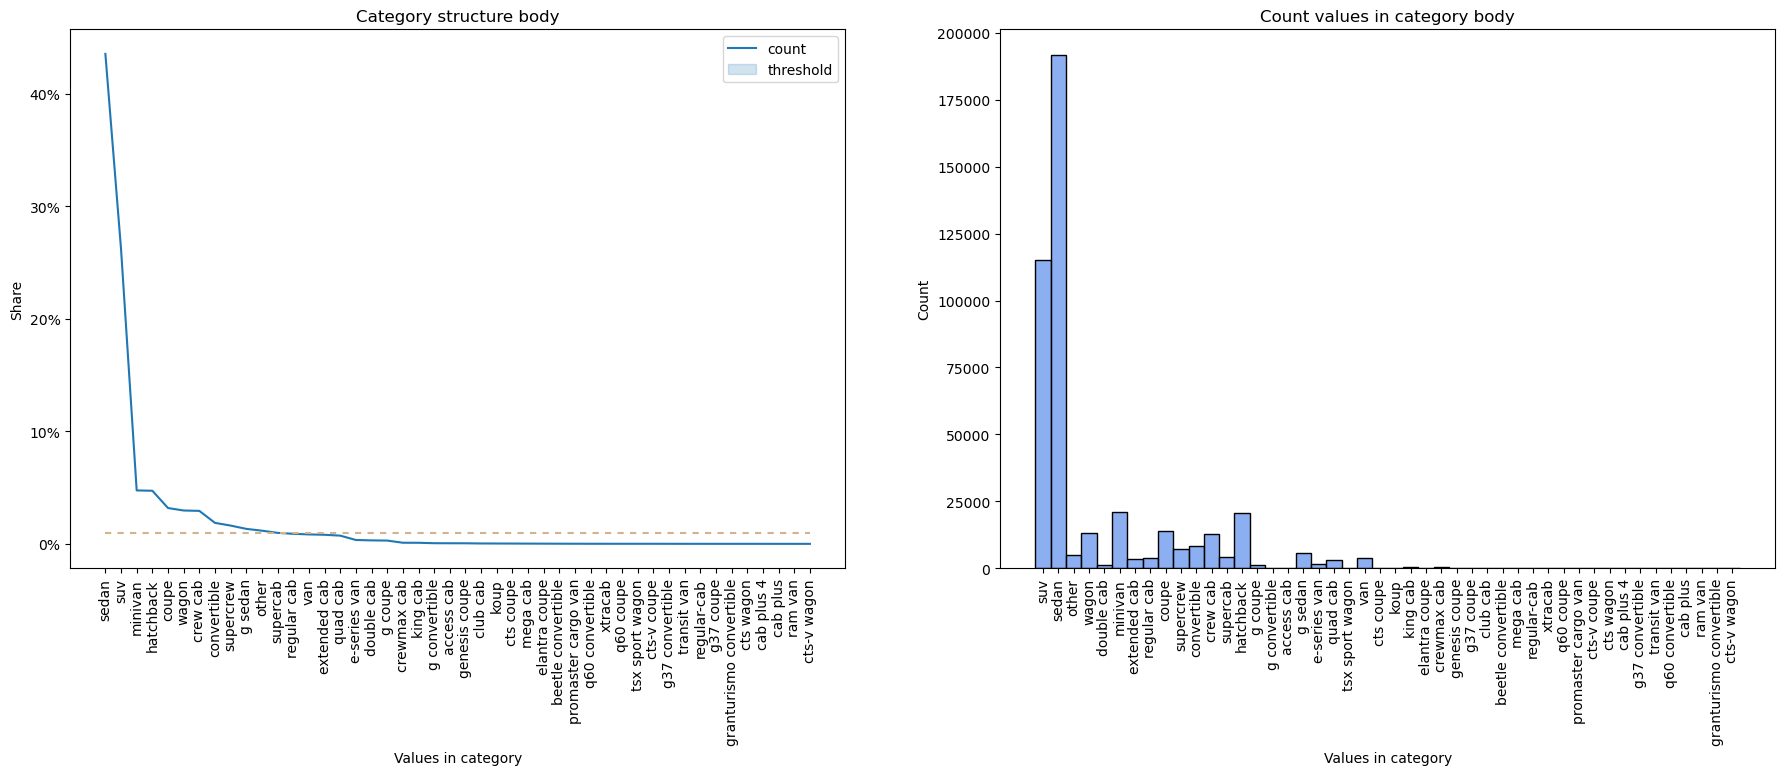

In [13]:
show_base_info_category_columns(df, 'body')

In [14]:
def truncate_values(df, column):
    clear_values = df[column].value_counts().to_frame()
    clear_values = clear_values.loc[clear_values[column] < 1000].index.unique()
    df[column] = df[column].apply(lambda x: 'other' if x in clear_values else x)
    return clear_values

In [15]:
clear_values = truncate_values(df, 'body')
print(df.body.unique())
test['body'] = test['body'].apply(lambda x: 'other' if x in clear_values else x)

['suv' 'sedan' 'other' 'wagon' 'double cab' 'minivan' 'extended cab'
 'regular cab' 'coupe' 'supercrew' 'convertible' 'crew cab' 'supercab'
 'hatchback' 'g coupe' 'g sedan' 'e-series van' 'quad cab' 'van']


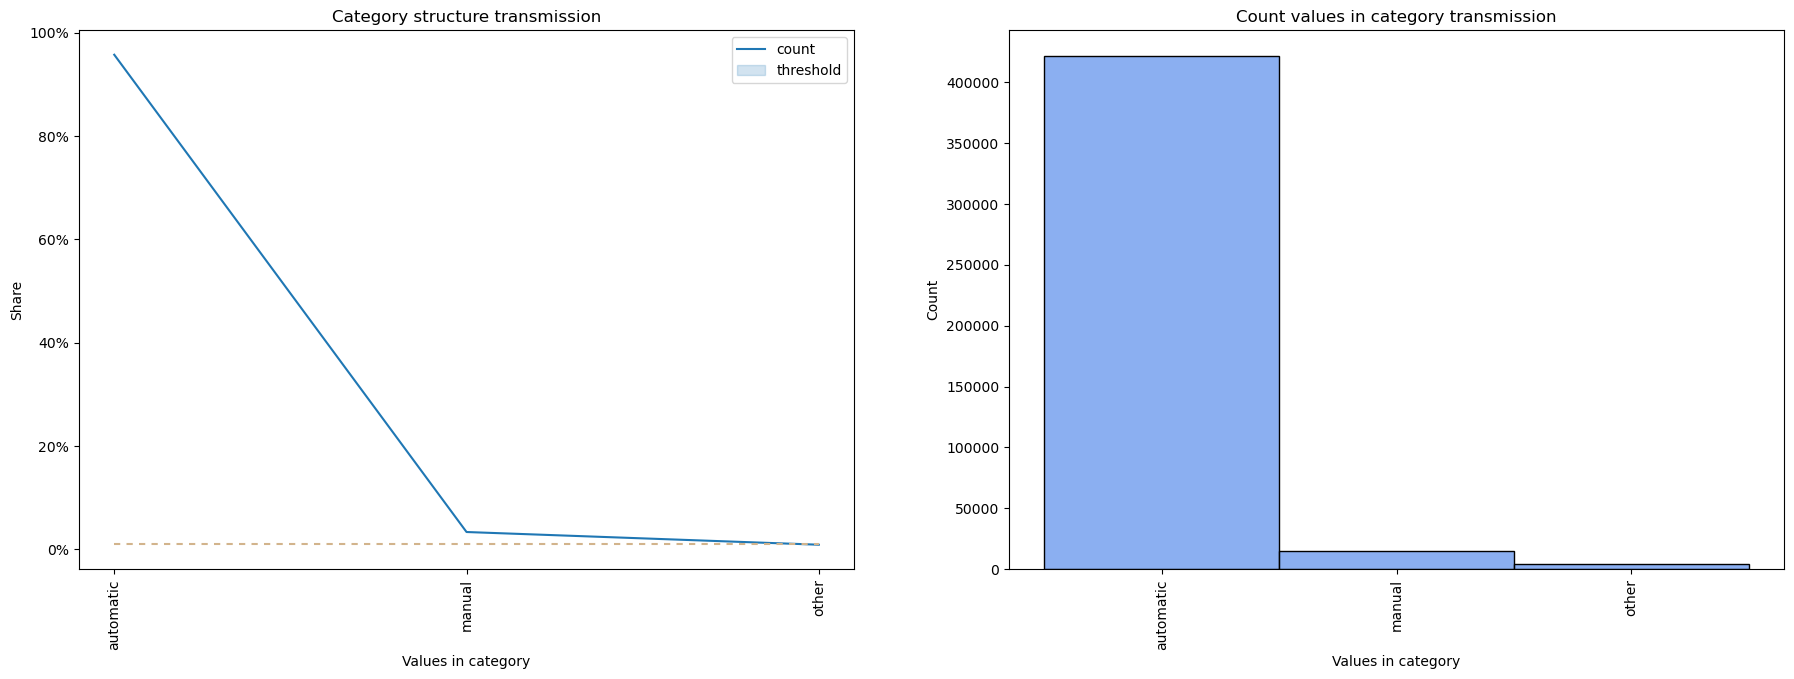

In [16]:
show_base_info_category_columns(df, 'transmission')

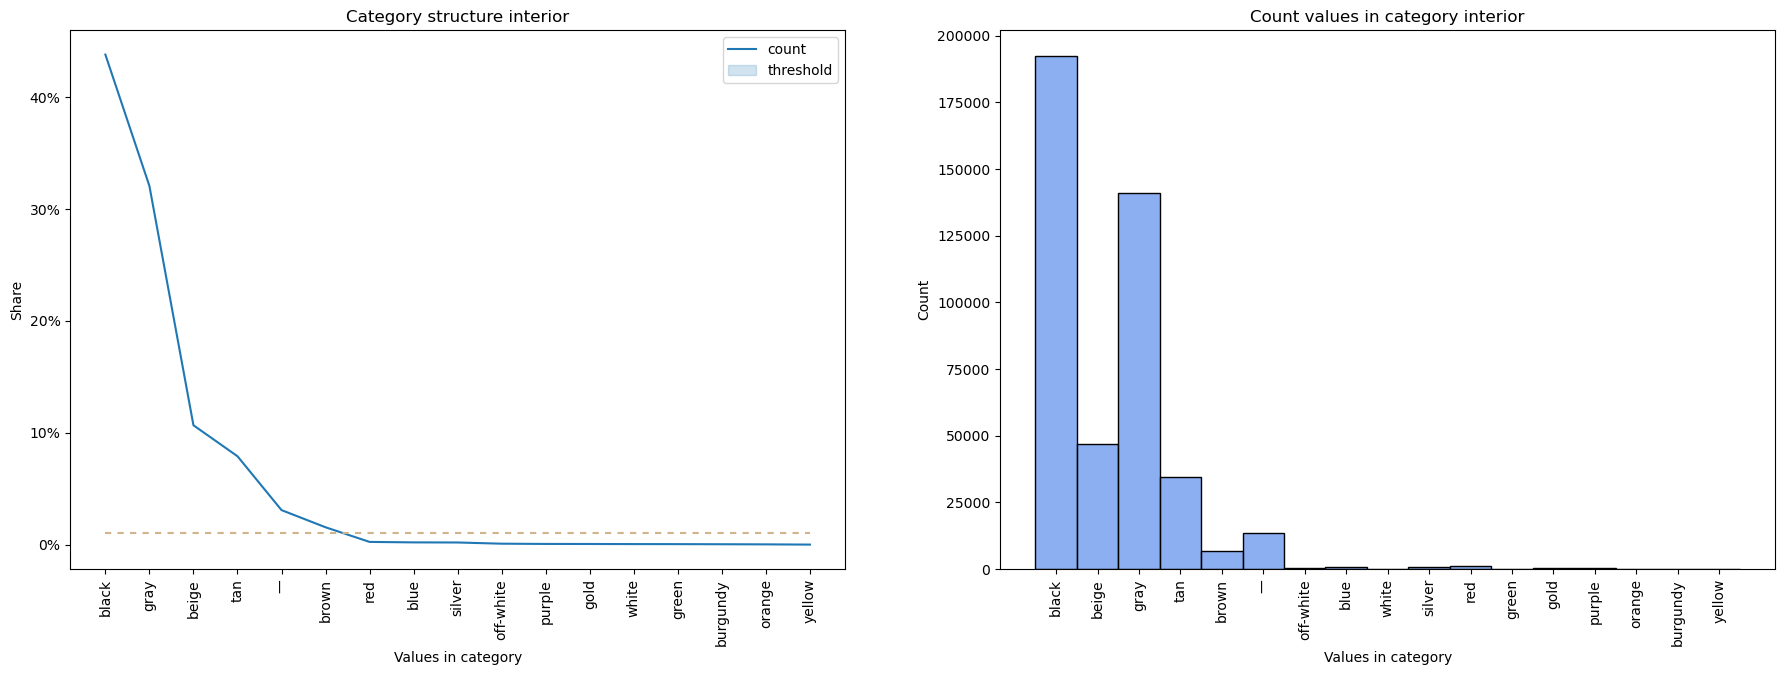

In [17]:
show_base_info_category_columns(df, 'interior')

In [18]:
df['interior'] = df['interior'].str.replace('—', 'other').fillna('other')
test['interior'] = test['interior'].str.replace('—', 'other').fillna('other')

clear_values = truncate_values(df, 'interior')
print(df.interior.unique())
test['interior'] = test['interior'].apply(lambda x: 'other' if x in clear_values else x)

['black' 'beige' 'gray' 'tan' 'brown' 'other' 'red']


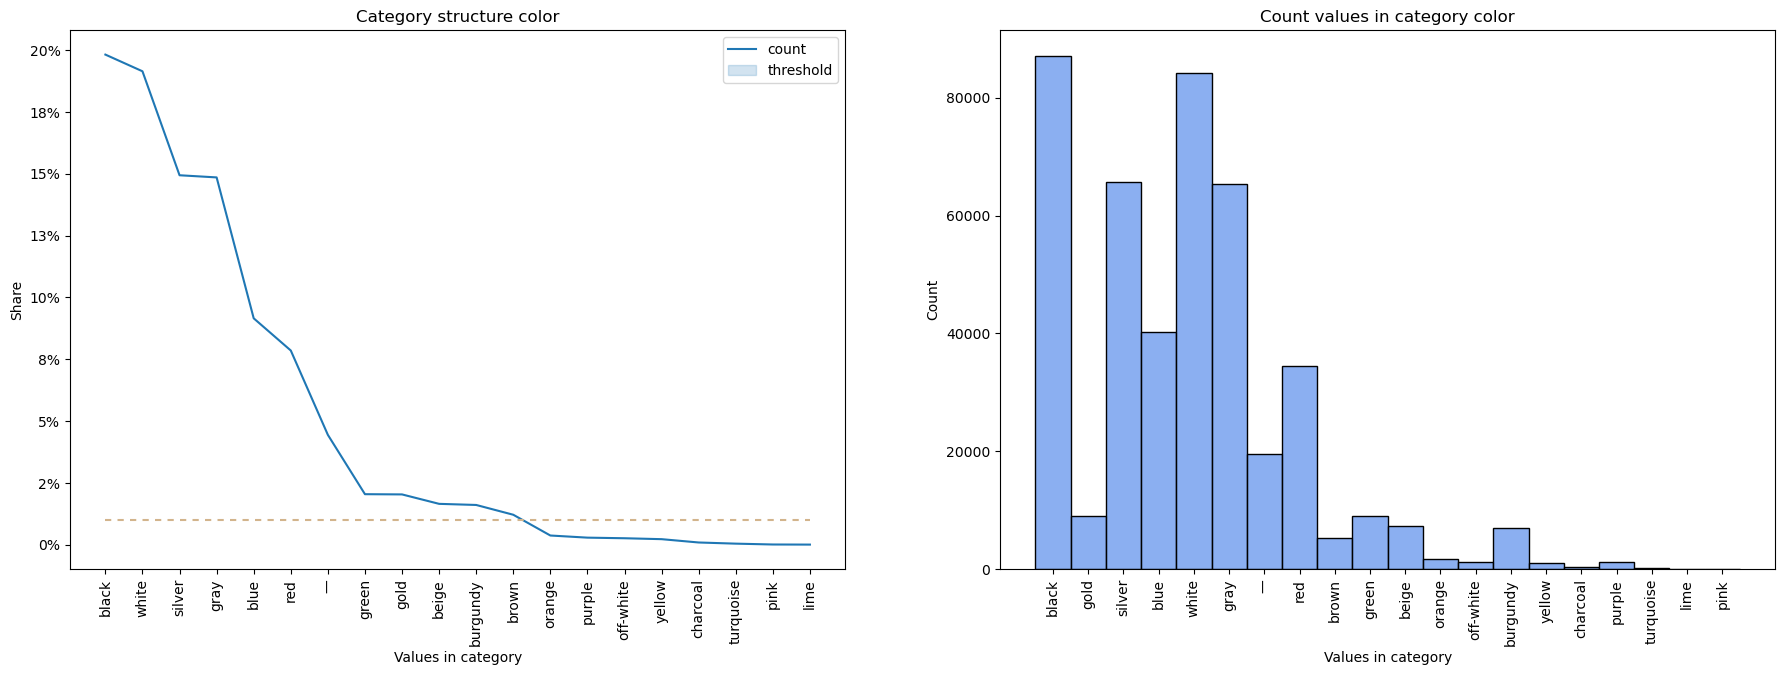

In [19]:
show_base_info_category_columns(df, 'color')

In [20]:
df['color'] = df['color'].str.replace('—', 'other').fillna('other')
test['color'] = test['color'].str.replace('—', 'other').fillna('other')

clear_values = truncate_values(df, 'color')
print(df.color.unique())
test['color'] = test['color'].apply(lambda x: 'other' if x in clear_values else x)

['black' 'gold' 'silver' 'blue' 'white' 'gray' 'other' 'red' 'brown'
 'green' 'beige' 'orange' 'off-white' 'burgundy' 'purple']


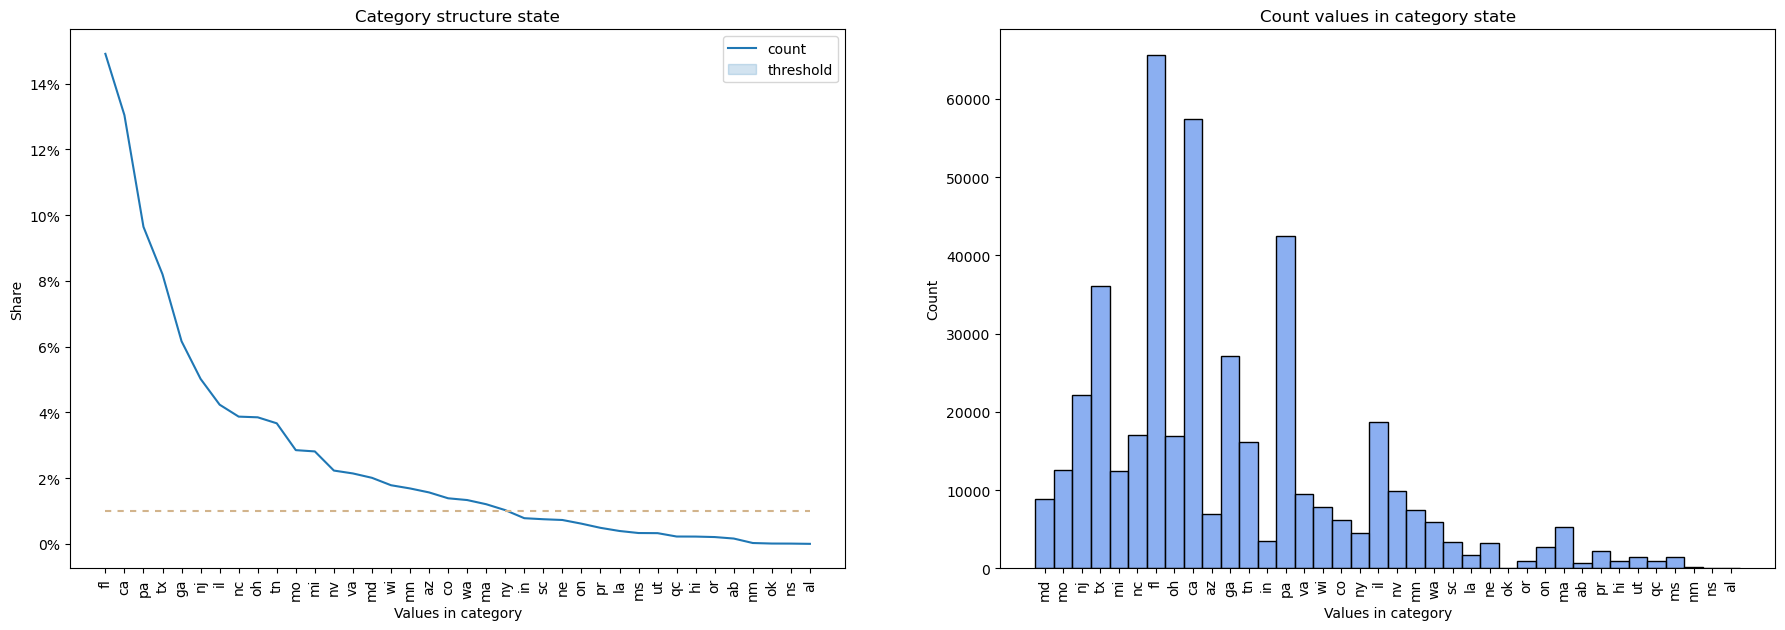

In [21]:
show_base_info_category_columns(df, 'state')

In [22]:
clear_values = truncate_values(df, 'state')
print(df.state.unique())
test['state'] = test['state'].apply(lambda x: 'other' if x in clear_values else x)

['md' 'mo' 'nj' 'tx' 'mi' 'nc' 'fl' 'oh' 'ca' 'az' 'ga' 'tn' 'in' 'pa'
 'va' 'wi' 'co' 'ny' 'il' 'nv' 'mn' 'wa' 'sc' 'la' 'ne' 'other' 'on' 'ma'
 'pr' 'ut' 'qc' 'ms']


Теперь поработаем с датой. Предполагаю, что нам может пригодится день, месяц, год и возможно сама дата в удобном формате. Получим эти признаки.

In [23]:
for frame in [df, test]:
    frame['saledate'] = pd.to_datetime(frame['saledate'], utc=True)
    frame['year_sale'] = frame['saledate'].dt.year
    frame['month'] = frame['saledate'].dt.month
    frame['weekday'] = frame['saledate'].dt.weekday
    frame['saledate_2'] = frame['saledate'].dt.to_period('D').astype('str')

Когда пропуски заполнены, настало время проанализировать категориальные признаки.

In [24]:
def show_graf_category(df, column):
    sns.despine(plt.figure(figsize=(22, 10)), left=True, bottom=True)
    ax = plt.subplot(2, 2, 1)
    plt.title(f'Зависимость цены от категории {column}')
    plt.xticks(rotation=90)
    sns.histplot(data=df, x = column, y= 'sellingprice', palette='YlGnBu', multiple='stack', shrink=.8, alpha = 0.7)

    ax = plt.subplot(2, 2, 2)
    sns.boxplot(data=df, y = 'sellingprice', x = column, color = 'cornflowerblue',)
    plt.title(f'Разброс цен в категории {column}')
    sns.lineplot(df, x=df[column], y=df['sellingprice'].mean(), style=True, dashes=[(3,3)], color = 'salmon')
    sns.lineplot(df, x=df[column], y=df['sellingprice'].median(), style=True, dashes=[(4,4)], color = 'brown')
    plt.legend(['mean', 'median'])
    plt.ylim(0, 100000)
    plt.xticks(rotation=90)
    
    plt.show()

Итак, мы видим:

 - Лидерами продаж среди брендов являются товары морок Форд, Ниссан, Тойота, Шевролет, Киа. Тогда как самые дорогие продажи были совершены по брендам Бентли, Роллс-ройс, Феррари. Средняя цена продажи 12 тыс. долларов.
 - Цена зависит и от типа кузова. Наиболее популярны седаны.
 - Машины с автоматической коробкой передач продаются чаще.
 - Разбос цен по нестандартным цветам отделки машины выше. Базовые цвета идут примерно с одинаковой стоимостью, большинство машин продается в стандартных цветах. Хочешь яркую и заметную машину - плати больше. 

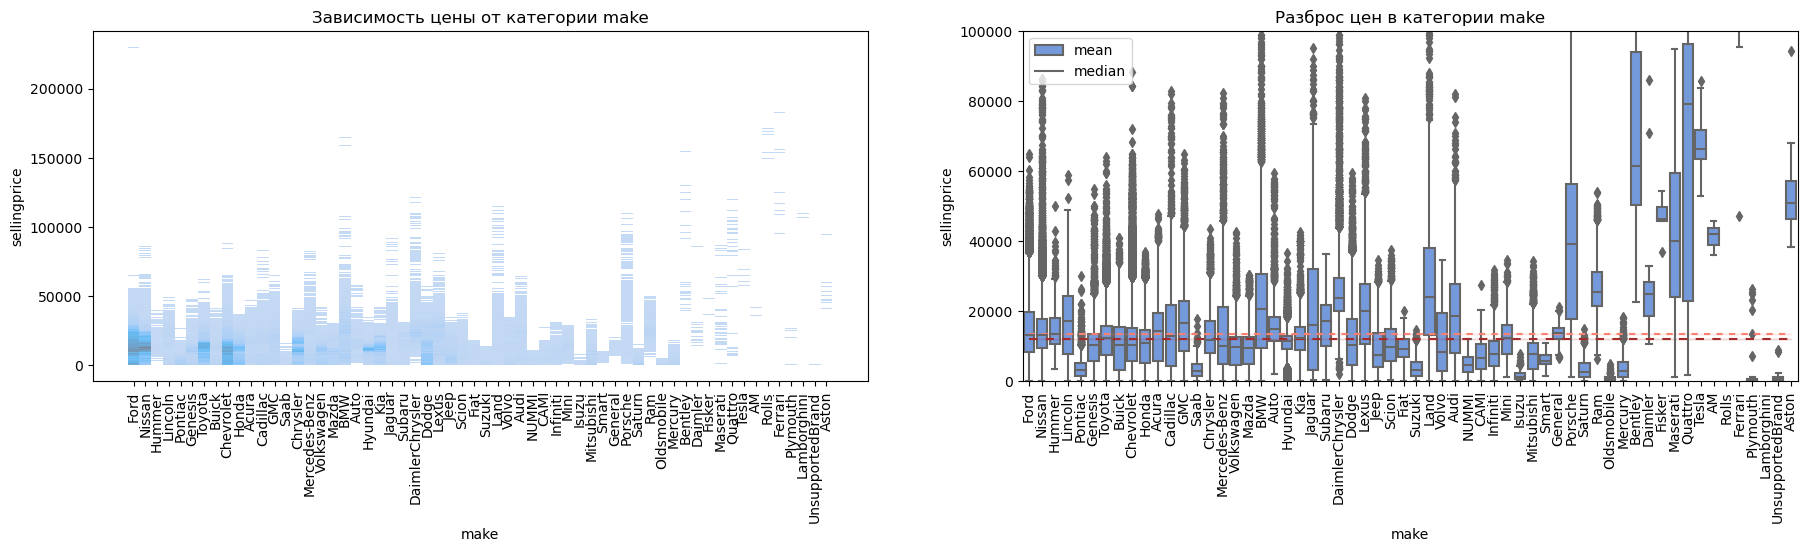

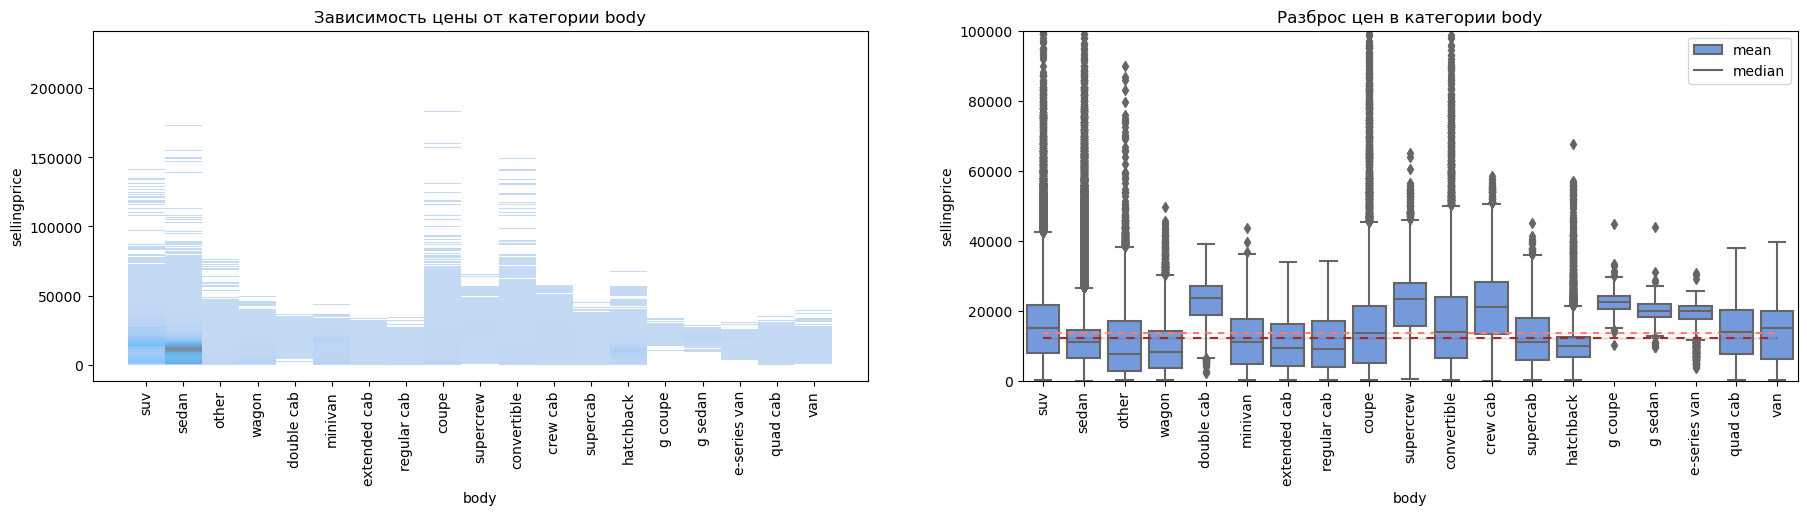

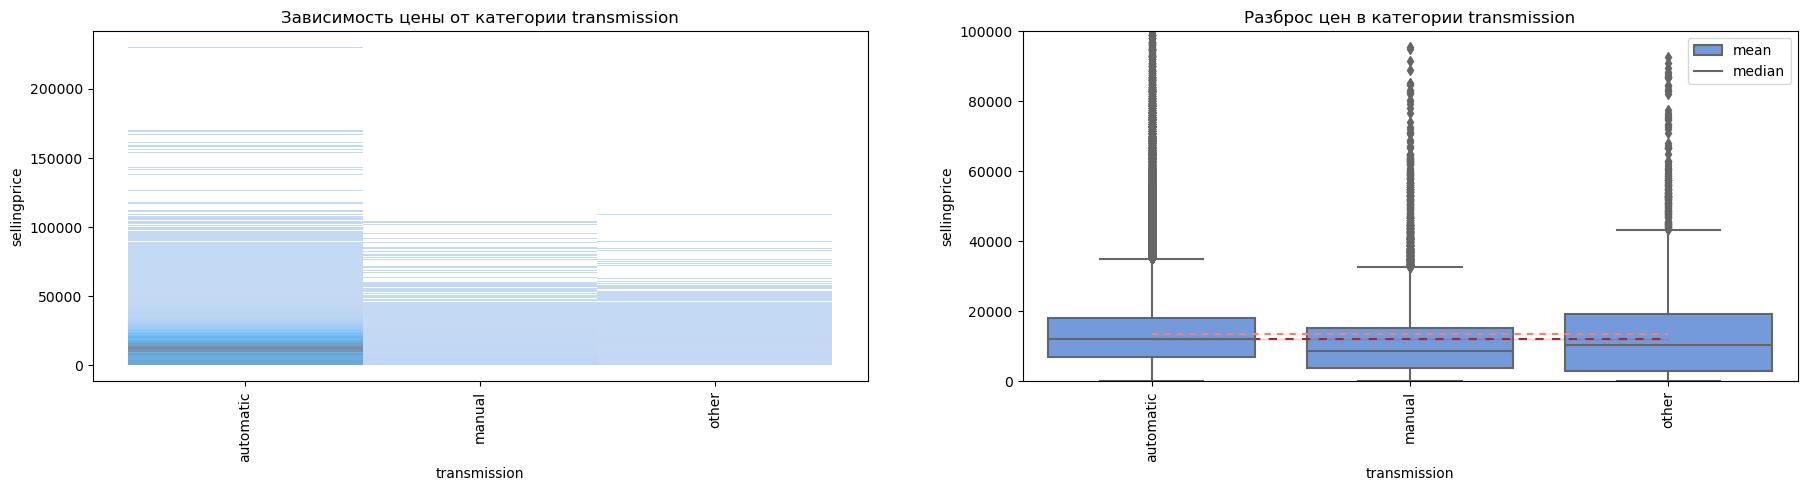

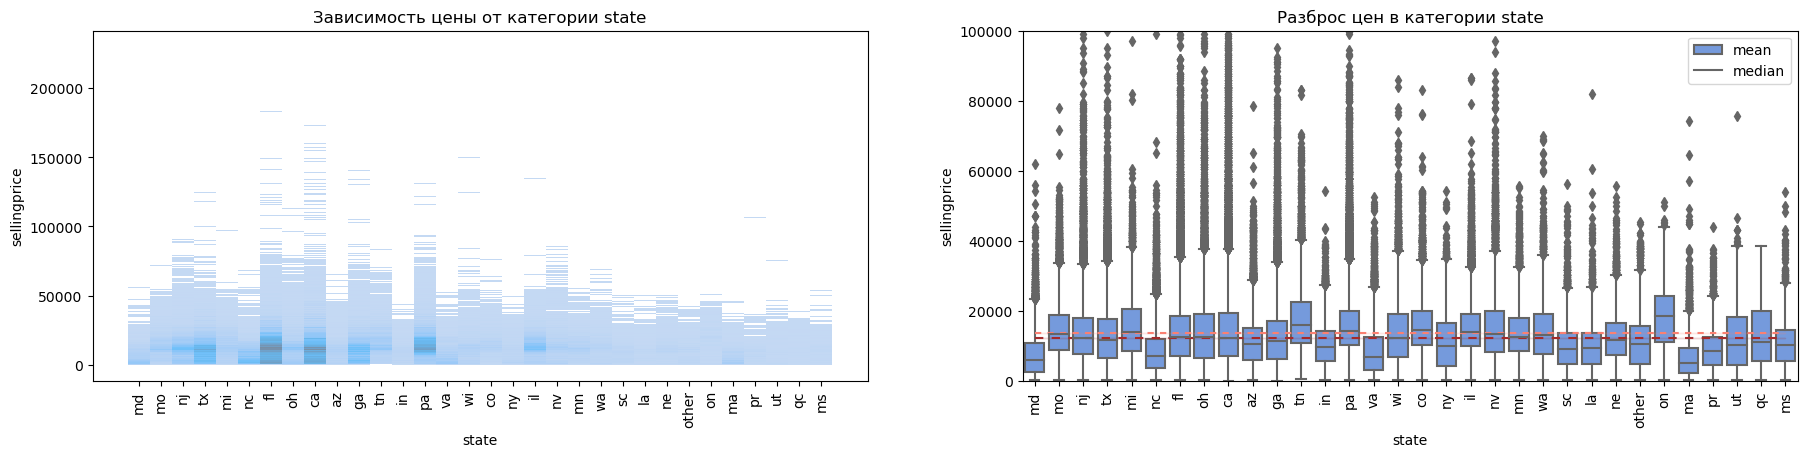

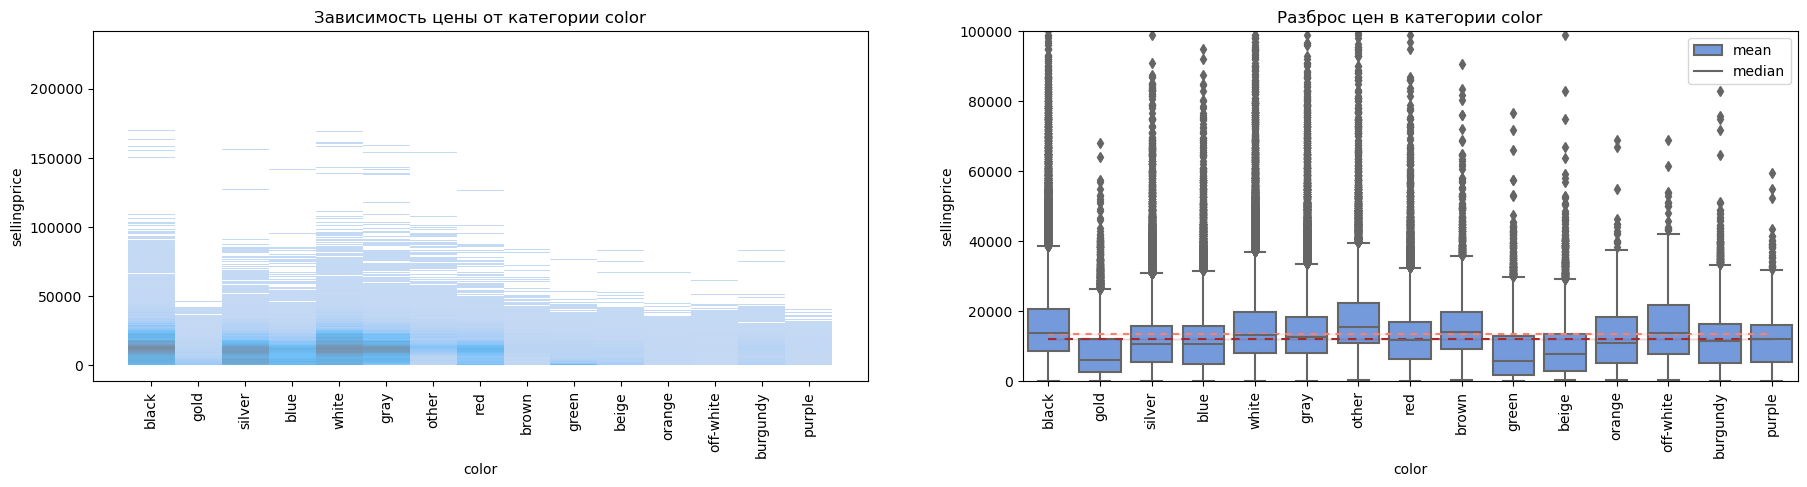

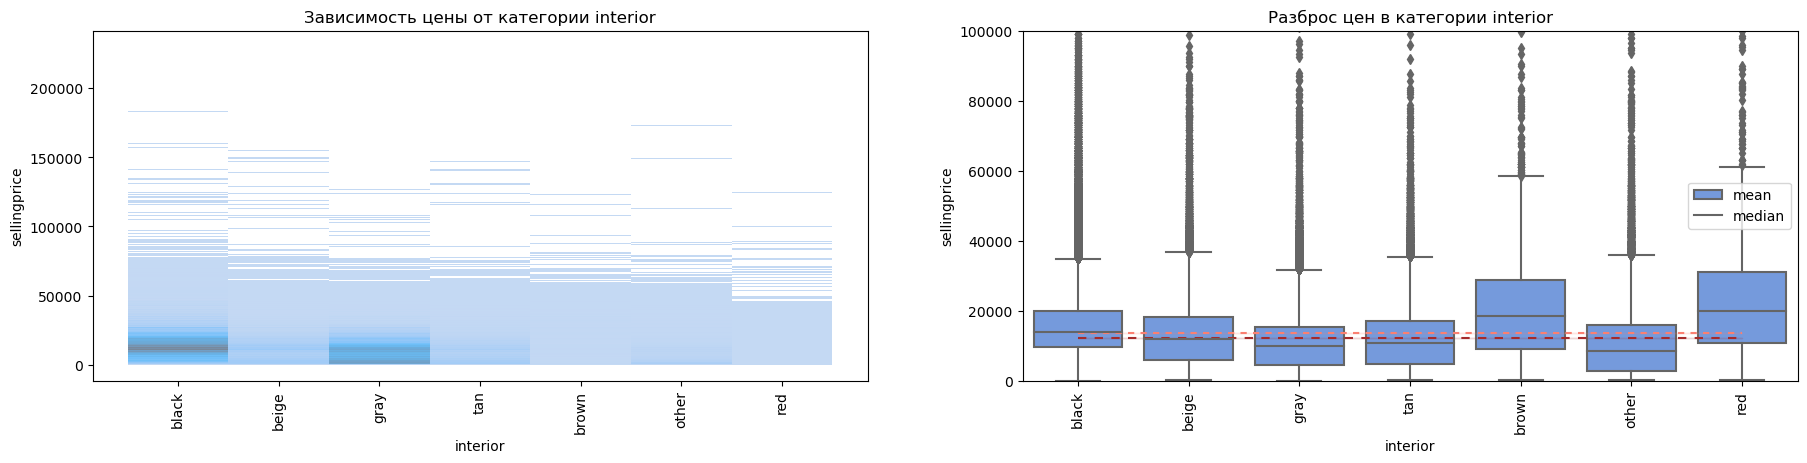

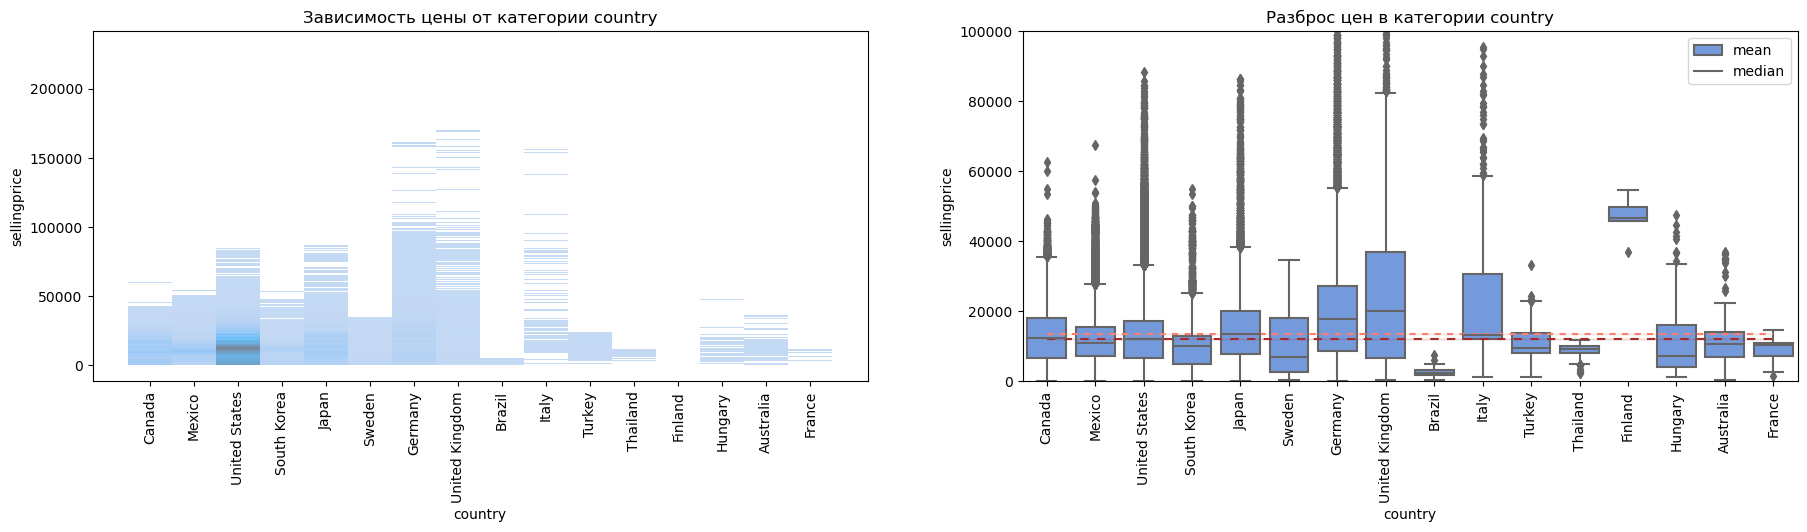

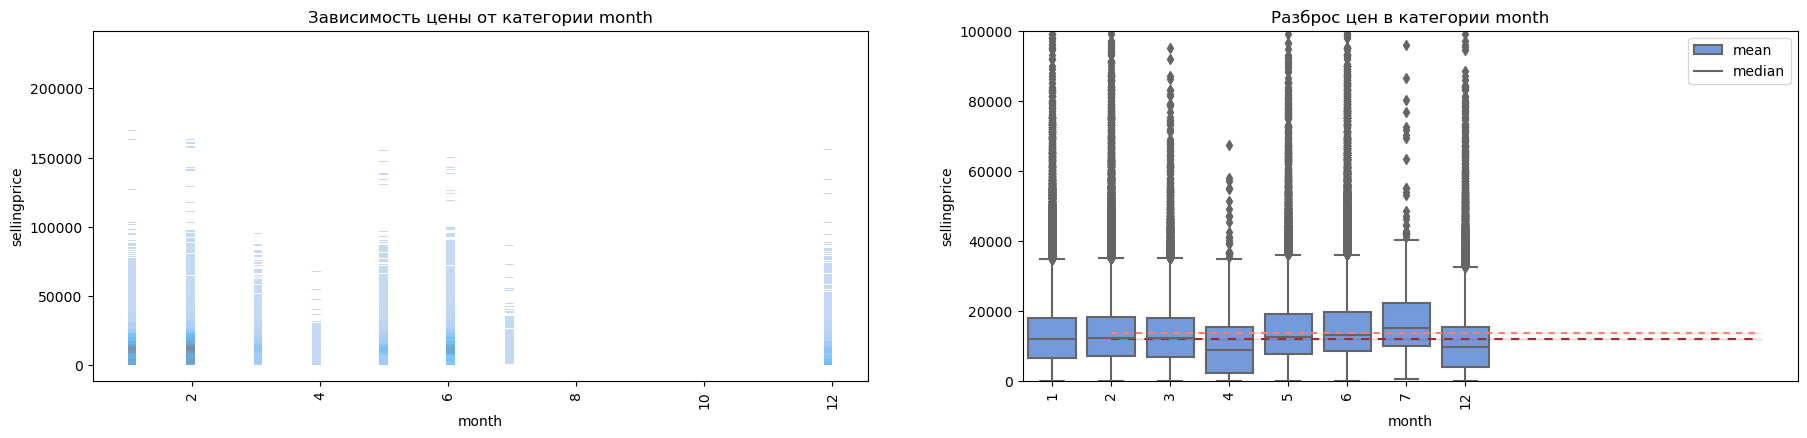

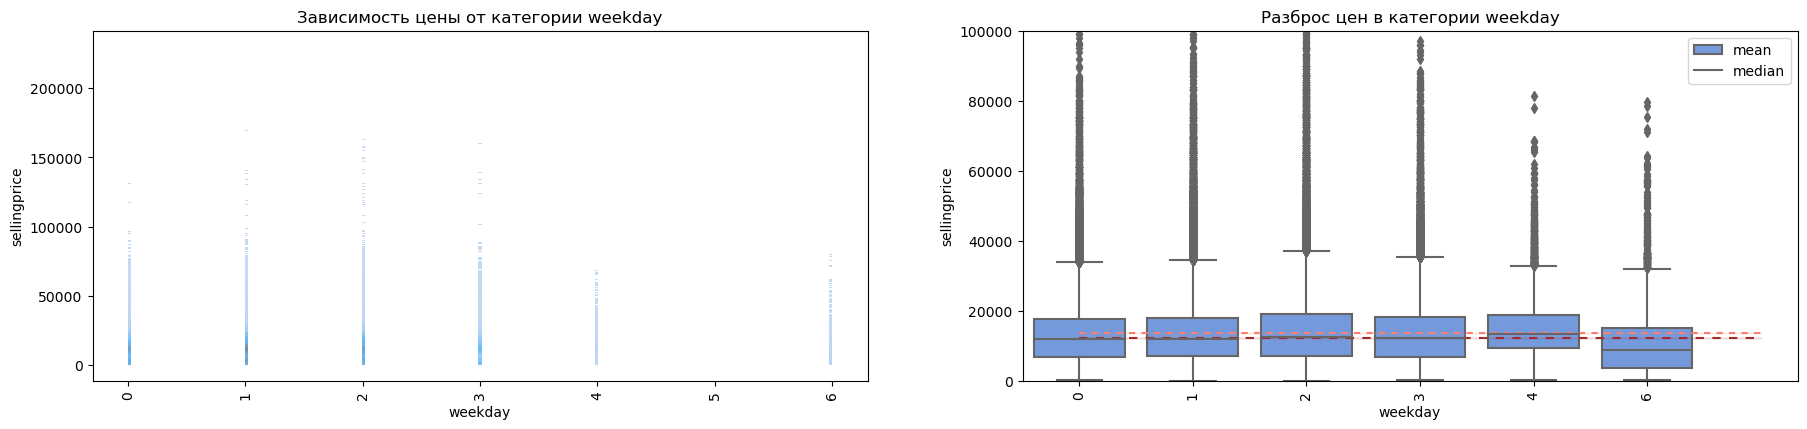

In [25]:
for category in ['make', 'body', 'transmission', 'state',
       'color', 'interior', 'country', 'month', 'weekday']:
    show_graf_category(df, category)

У нас есть еще аномально низкие значения по цене продажи. Сперва посмотрим на них в разрезе показателя кондиции и возраста авто. Как и предполагалось, в интервале с 1 до 3 баллов кондиции присуствуют старые авто с низкой ценой. Подрегулируем для них порог минимальной цены, установив его до значения 300 долларов. Те авто, которые были проданы в хорошем состоянии, но по низкой цене уберем как выбросы. Для остальных случаев установим минимальный порог в 10% квантиль по каждому бренду авто.

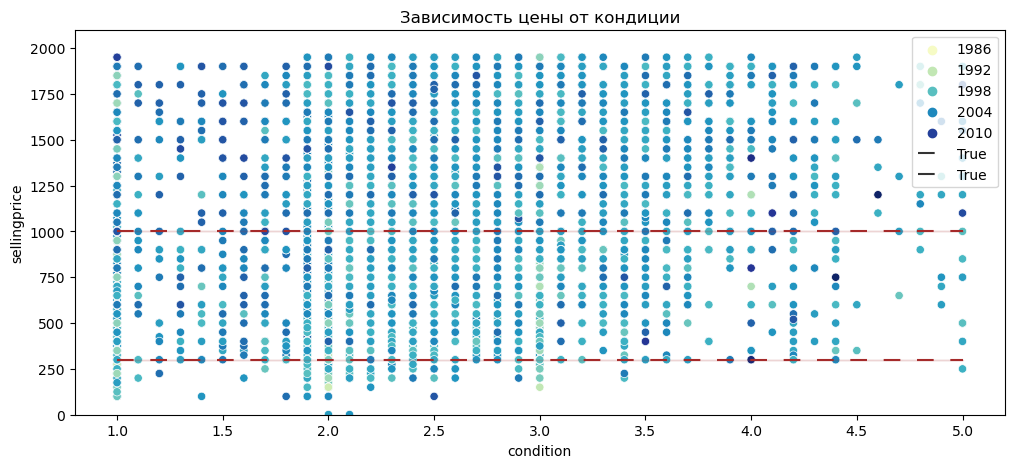

In [26]:
plt.figure(figsize=(12, 5))
plt.title('Зависимость цены от кондиции')
sns.scatterplot(data=df.loc[df['sellingprice']<2000], y='sellingprice', x= 'condition', palette='YlGnBu', hue='year')
sns.lineplot(df, x=df['condition'], y=1000, style=True, dashes=[(8,8)], color = 'brown')
sns.lineplot(df, x=df['condition'], y=300, style=True, dashes=[(8,8)], color = 'brown')
plt.ylim(0,2100)
plt.show()

In [27]:
list_index_drop = []
for make in df.make.unique():
    index_drop = list(df.loc[(df['sellingprice']<df['sellingprice'].quantile(0.01))&(df['make']==make)&(df['condition']>3)].index)
    #index_drop = list(df.loc[(df['sellingprice']<df['sellingprice'].quantile(0.2))&(df['make']==make)].index)
    list_index_drop.extend(index_drop)

print(f'number of values to be removed: {len(list_index_drop)}')

print('_________')
print('Size frame before drop index:', df.shape)
df = df.drop(index = list_index_drop)
df.loc[df['sellingprice']<300]['sellingprice']=300
print('Size frame after:', df.shape)

number of values to be removed: 56
_________
Size frame before drop index: (440236, 27)
Size frame after: (440180, 27)


Теперь, когда мы обработали выбросы по цене, можно изучить ее отклонение в периодах продаж. Получим средние цены по брендам в разрезе периода и соотнесем их с ценами предыдущего периода продаж.

In [28]:
df_group = df.groupby(by = ['make', 'year_sale', 'month'])['sellingprice'].agg(['mean', 'median']).reset_index()
df_group_diff = df.groupby(by = ['make', 'year', 'month'])['sellingprice'].diff().fillna(0).reset_index()
df_group['diff_mean'] = np.where((df_group['make']==df_group['make'].shift(1)),
                            df_group['mean']/df_group['mean'].shift(1)-1, 0)
df_group['diff_median'] = np.where((df_group['make']==df_group['make'].shift(1)),
                            df_group['median']/df_group['median'].shift(1)-1, 0)
df_group.head(10)

,make,year_sale,month,mean,median,diff_mean,diff_median
0,AM,2015,2,39000.000000,39000.0,0.000000,0.000000
1,AM,2015,5,45750.000000,45750.0,0.173077,0.173077
2,Acura,2014,1,14800.000000,14800.0,0.000000,0.000000
3,Acura,2014,12,13003.303571,13600.0,-0.121398,-0.081081
4,Acura,2015,1,14365.137131,15700.0,0.104730,0.154412
5,Acura,2015,2,13665.741460,13600.0,-0.048687,-0.133758
6,Acura,2015,3,12293.527508,10400.0,-0.100413,-0.235294
7,Acura,2015,4,8000.000000,8000.0,-0.349251,-0.230769
8,Acura,2015,5,13611.674528,14600.0,0.701459,0.825000
9,Acura,2015,6,14276.820728,15050.0,0.048866,0.030822


Накопительная инфляция составила 21%. За два года это прямо большое значение, принимая во внимание еще и то, что официальная инфляция в США в те периоды не превышала 2,5%, мы получили аномально завышенный показатель. Значит это не инфляционные изменения, а то, что в пределах разных периодов мы имеем разные продажи по моделям авто и по их состоянию. Правильней было бы вычислить инфляцию на примере продаж одинаковых авто, а не агрегированных по брендам данных.

In [29]:
inf = df_group.loc[df_group['diff_mean']!=0].groupby(by=['make'])[['diff_mean','diff_median']].sum().reset_index()
inf['koef'] = (inf['diff_mean']+inf['diff_median'])/2*100
inf = inf.merge(
    df_group.loc[df_group['diff_mean']!=0].groupby(by=['make'])[['mean']].mean().reset_index(),
    on = 'make')
inf['mean'] = inf['mean']/1000
inf.head(2)
print('inflation:', inf.loc[inf['mean']<150]['mean'].mean())

inflation: 21.060202792434065


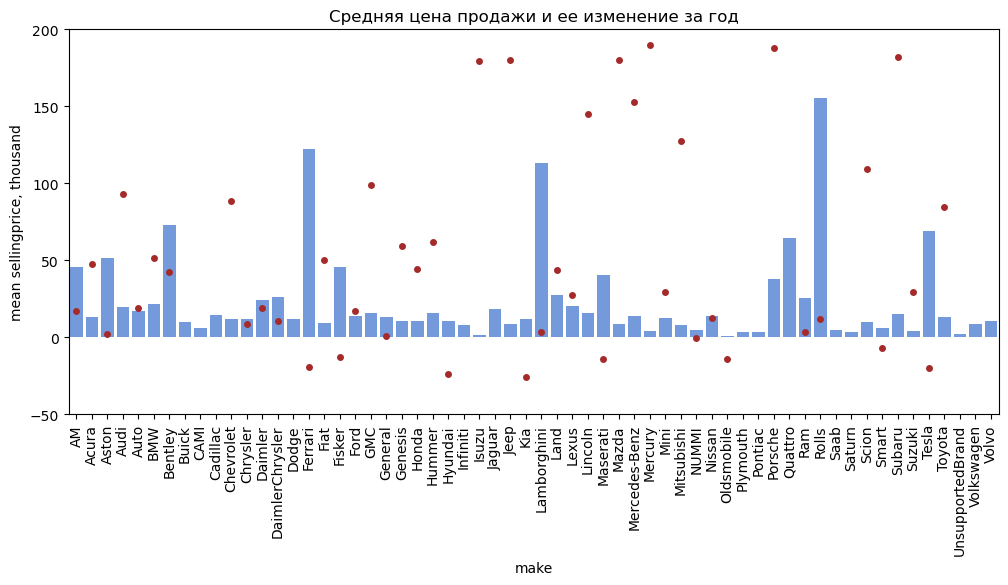

In [30]:
plt.figure(figsize=(12, 5))
sns.stripplot(data=inf, x='make', y = 'koef', size=5, color='brown')
sns.barplot(data=inf, x='make', y='mean', color='cornflowerblue')
plt.ylim(-50,200)
plt.title('Средняя цена продажи и ее изменение за год')
plt.ylabel('mean sellingprice, thousand')
plt.xticks(rotation=90)
plt.show()

Еще в качестве синтетического признака неплохо было бы применить коэффициенты соотношения цены модели к бренду и серии к модели. а так как мы не будем агрегировать данные по периодам а возьмем общие коэффициенты по всей обучающей выборке, это не будет являться утечкой данных. Для тестового набора данных применим коэффициенты и цены, посчитатнные ранее на обучающих данных.

In [31]:
df_relationship_price = df.groupby(by=['make', 'model'])['sellingprice'].mean().reset_index()\
                        .merge(df.groupby(by=['make'])['sellingprice'].mean().reset_index(), on = ['make'])\
                        .rename(columns = {'sellingprice_x': 'price_model', 'sellingprice_y': 'price_make'})

df_relationship_price['koef_relationship'] = df_relationship_price['price_model']/df_relationship_price['price_make']
display(df_relationship_price.head())

df = df.merge(df_relationship_price[['make', 'model', 'price_make','price_model','koef_relationship']], on=['make', 'model'], how = 'left')
test = test.merge(df.groupby(by=['make'])['sellingprice'].mean().reset_index().rename(columns = {'sellingprice': 'price_make'}),\
                  on=['make'], how = 'left')
test = test.merge(df_relationship_price[['make', 'model','price_model','koef_relationship']], on=['make', 'model'], how = 'left')

for make in df_relationship_price['make'].unique():
    mean_koef = df_relationship_price.loc[df_relationship_price['make']==make]['koef_relationship'].mean()
    test.loc[(test['koef_relationship'].isna())&(test['make']==make), 'koef_relationship'] = mean_koef
    test.loc[(test['price_model'].isna())&(test['make']==make), 'price_model'] = mean_koef*test.loc[(test['price_make'].isna())&(test['make']==make)]['price_model'] 

test['price_make'] = test['price_make'].fillna(df.loc[df['year']==2007]['price_make'].mean())

,make,model,price_model,price_make,koef_relationship
0,AM,h1,45750.000000,41250.000000,1.109091
1,AM,other,39000.000000,41250.000000,0.945455
2,Acura,cl,2053.896104,13799.904863,0.148834
3,Acura,el,4600.000000,13799.904863,0.333336
4,Acura,ilx,18800.000000,13799.904863,1.362328


In [32]:
df_relationship_price = df.groupby(by=['make', 'model', 'trim'])['sellingprice'].mean().reset_index()\
                        .merge(df.groupby(by=['make', 'model'])['sellingprice'].mean().reset_index(), on = ['make', 'model'])\
                        .rename(columns = {'sellingprice_x': 'price_trim', 'sellingprice_y': 'price_model'})

df_relationship_price['koef_relationship_trim'] = df_relationship_price['price_trim']/df_relationship_price['price_model']
display(df_relationship_price.head())

df = df.merge(df_relationship_price[['make', 'model', 'trim', 'koef_relationship_trim']], on=['make', 'model', 'trim'], how = 'left')
test = test.merge(df_relationship_price[['make', 'model', 'trim', 'koef_relationship_trim']], on=['make', 'model', 'trim'], how = 'left')

for make in df_relationship_price['make'].unique():
    mean_koef = df_relationship_price.loc[df_relationship_price['make']==make]['koef_relationship_trim'].mean()
    test.loc[(test['koef_relationship'].isna())&(test['make']==make), 'koef_relationship_trim'] = mean_koef

,make,model,trim,price_trim,price_model,koef_relationship_trim
0,AM,h1,wagon,45750.0,45750.000000,1.000000
1,AM,other,other,39000.0,39000.000000,1.000000
2,Acura,cl,2.2,862.5,2053.896104,0.419934
3,Acura,cl,2.2 premium,470.0,2053.896104,0.228833
4,Acura,cl,2.3,1050.0,2053.896104,0.511224


## Обработка и анализ числовых признаков

Приступим к обработке числовых признаков.

In [33]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_features].describe()

,year,condition,odometer,sellingprice,year_sale,month,weekday,price_make,price_model,koef_relationship,koef_relationship_trim
count,440180.000000,430775.000000,440111.000000,440180.000000,440180.000000,440180.000000,440180.000000,440180.000000,440180.000000,440180.000000,440180.000000
mean,2010.041124,3.425032,68334.507249,13593.893646,2014.902515,3.816007,1.474288,13593.893646,13593.893646,1.000000,1.000000
std,3.976995,0.950011,53530.843430,9750.956181,0.296618,3.244833,1.243287,4403.345785,7014.468909,0.392953,0.309675
min,1982.000000,1.000000,1.000000,1.000000,2014.000000,1.000000,0.000000,900.694444,125.000000,0.012053,0.019895
25%,2007.000000,2.700000,28257.000000,6900.000000,2015.000000,1.000000,1.000000,11934.631481,9315.633876,0.770157,0.897201
50%,2012.000000,3.600000,52094.000000,12100.000000,2015.000000,2.000000,1.000000,12445.549940,12557.432003,0.956975,1.000000
75%,2013.000000,4.200000,99259.500000,18200.000000,2015.000000,6.000000,2.000000,14264.013646,17447.636632,1.225340,1.106831
max,2015.000000,5.000000,999999.000000,230000.000000,2015.000000,12.000000,6.000000,155450.000000,183000.000000,7.093783,7.838536


In [34]:
df[numerical_features].isna().sum()

year                         0
condition                 9405
odometer                    69
sellingprice                 0
year_sale                    0
month                        0
weekday                      0
price_make                   0
price_model                  0
koef_relationship            0
koef_relationship_trim       0
dtype: int64

Сперва переведем пробег в более читаемый вид - тысячи километров.

In [35]:
for frame in [df, test]:
    frame['odometer_thousand'] = frame['odometer']/1000

In [36]:
def show_base_info_numerical_columns(df, column, mode=None):
    plt.figure(figsize=(25, 5))
    
    ax = plt.subplot(1, 3, 1)
    plt.title(f'Диаграмма размаха по признаку {column}')
    sns.boxplot(data=df, y=column, color='cornflowerblue')
    sns.stripplot(data=df, y=column, color='bisque', alpha=0.3)

    ax = plt.subplot(1, 3, 2)
    sns.histplot(data=df, x=column, color='cornflowerblue', alpha = 0.7)
    plt.axvline(x=df[column].mean(), color='salmon', linestyle = '--')
    plt.axvline(x=df[column].median(), color='brown', linestyle = '--')
    plt.legend(['mean', 'median'])
    plt.title(f'Распределение признака {column}')

    ax = plt.subplot(1, 3, 3)
    sns.histplot(data=df, x=column, y= 'sellingprice', palette='YlGnBu', multiple='stack', shrink=.8, alpha = 0.7)
    if mode is not None:
        plt.xlim(0, 300)
    plt.legend(['mean', 'median'])
    plt.title(f'Зависимость цены от {column}')
    
    plt.show()

Посмотрим на ключевые признаки:

 - В основном продаются относительно новые авто. Средний возраст продаваемых машин 5 лет, медианный - 3 года. Это в принципе логично, т.к. при таких показателях можно продать машину по хорошей цене, что и видно на графике - чем старше машина, тем ниже ее стоимость.
 - Основные продажи приходятся на машины с кондиционным показателям от 3,5 до 4,5, а также 1,9-2. Для последней группы максимальная цена продажи не превышает порог в 50000 долларов. Чем выше показатель кондиции, тем дороже можно продать авто.
 - Большая часть автомобилей имеет пробег до 150 тыс. км. Преположительно в этом признаке присуствуют выбросы, изучим их.

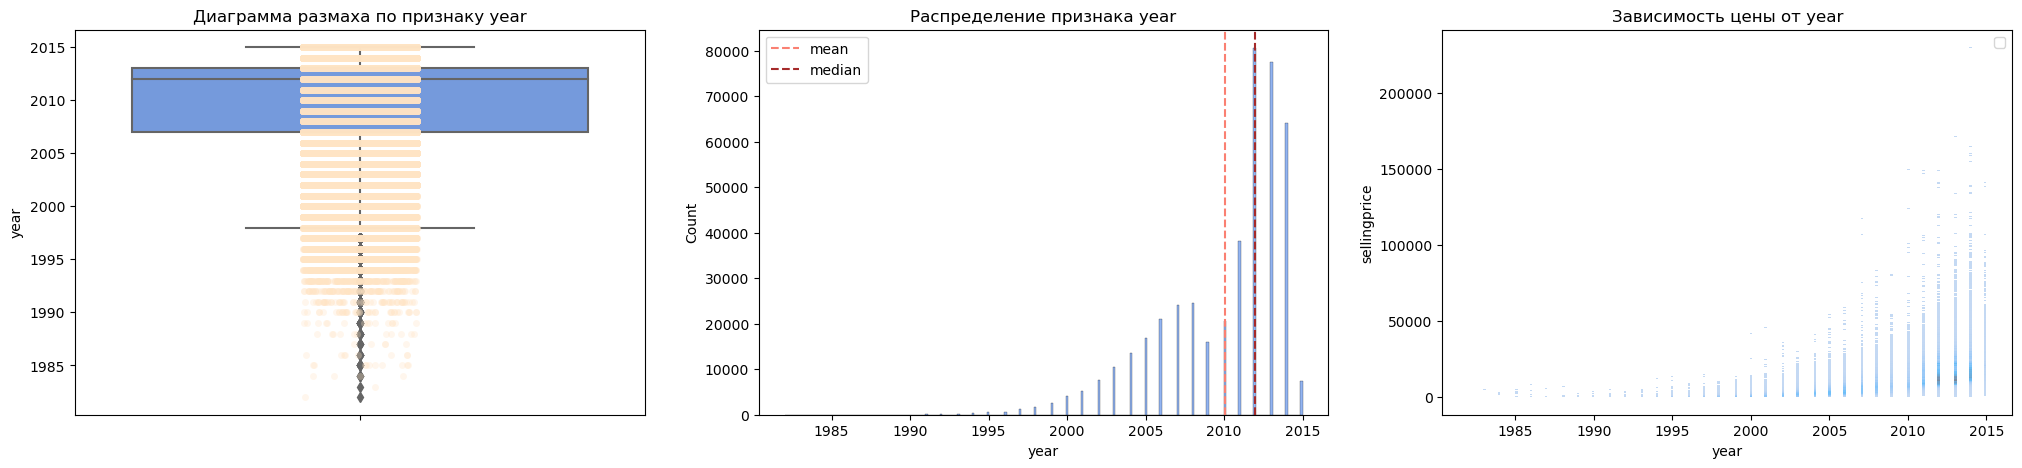

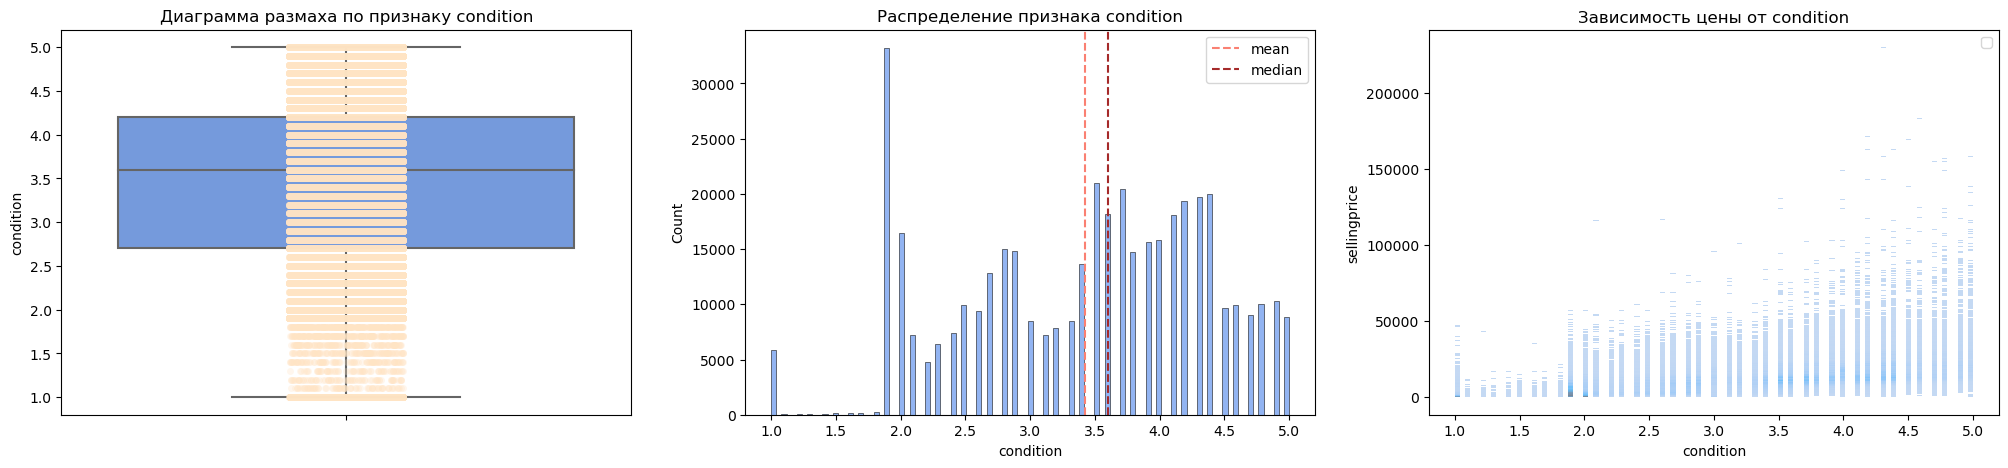

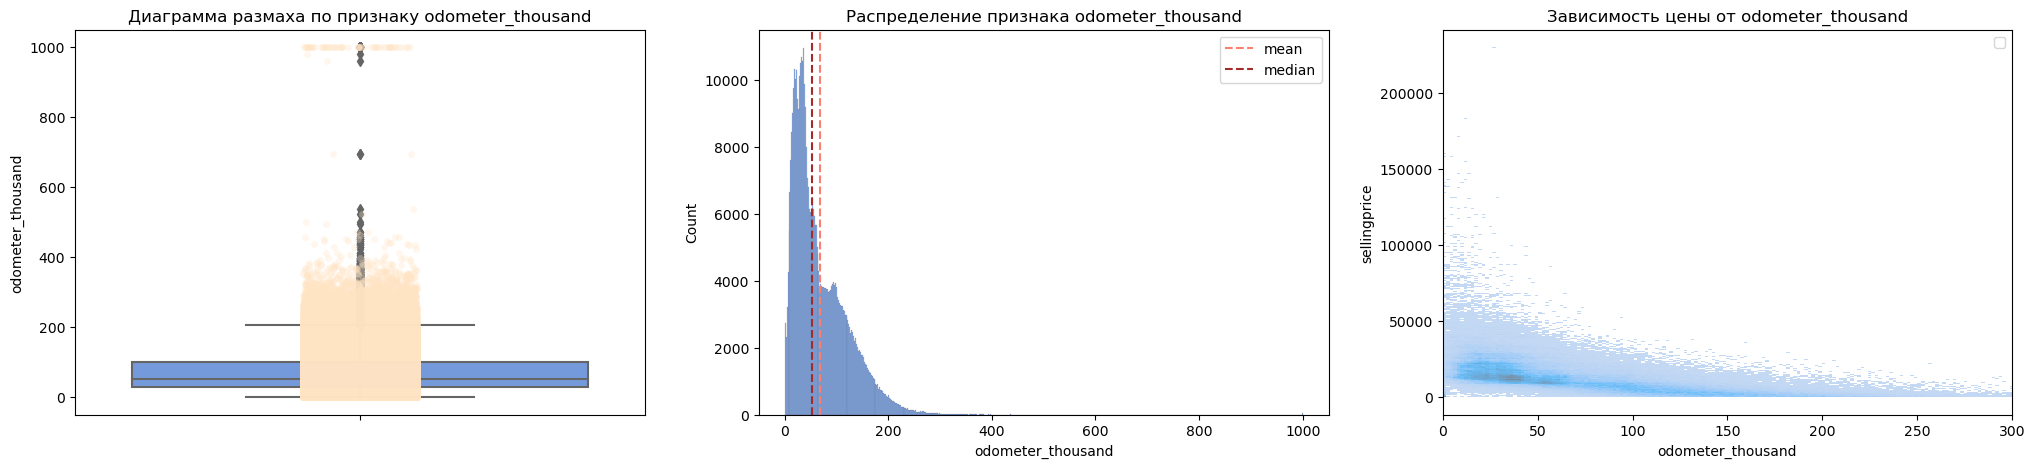

In [37]:
for column in ['year', 'condition', 'odometer_thousand']:
    if column == 'odometer_thousand':
        show_base_info_numerical_columns(df, column, 'o')
    else:
        show_base_info_numerical_columns(df, column)

В качестве гипотезы можно выдвинуть предположение, что машины с аномально большим пробегом имеют низкие показатели кондиции. В принципе это так (видно на графике). Но предел все же лучше опустить до 500 тыс. км. 

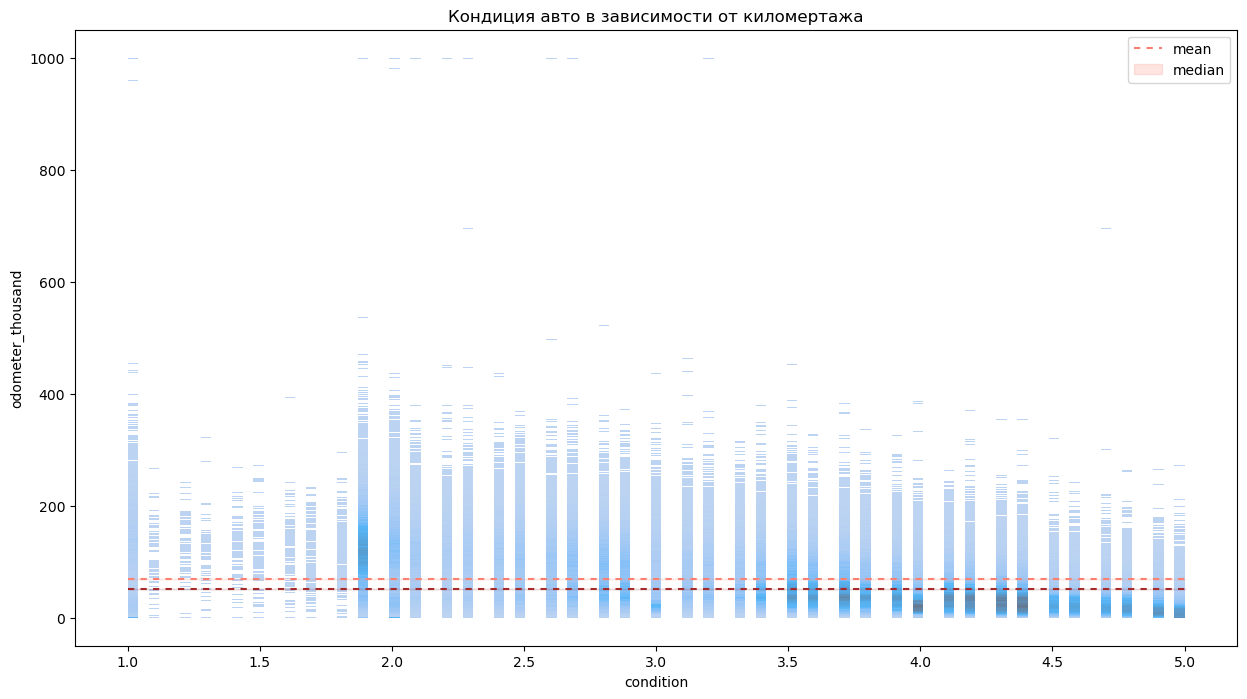

In [38]:
plt.figure(figsize=(15, 8))
plt.title('Кондиция авто в зависимости от киломертажа')
sns.histplot(data=df, y='odometer_thousand', x= 'condition', palette='YlGnBu', multiple='stack',  alpha = 0.8)
sns.lineplot(df, x='condition', y=df['odometer_thousand'].mean(), style=True, dashes=[(3,3)], color = 'salmon')
sns.lineplot(df, x='condition', y=df['odometer_thousand'].median(), style=True, dashes=[(3,3)], color = 'brown')
plt.legend(['mean', 'median'])
plt.show()

In [39]:
df.loc[(df['odometer_thousand']>500)&(df['condition']<3.5), 'odometer_thousand'] = 500

При высоких баллах кондиции километраж как правило небольшой. Это видно на графике - чем темнее зона графика, тем больше продаж совершено именно при таких показателях. Настораживает малый пробег при низкой кондиции. Это наверное машины. которые побывали в авариях, или например, продающиеся со снятой с производства комплектацией.

In [40]:
for year in df.loc[df['odometer_thousand']<1]['year'].unique():
    mean_odometer_thousand = df.loc[(df['year']==year)&(df['year']<2014)&(df['odometer_thousand']>1)]['odometer_thousand'].mean()
    df.loc[(df['odometer_thousand']<1)&(df['year']<2014)&(df['year']==year), 'odometer_thousand']= mean_odometer_thousand

for year in test.loc[test['odometer_thousand']<1]['year'].unique():
    mean_odometer_thousand = test.loc[(test['year']==year)&(df['year']<2014)&(test['odometer_thousand']>1)]['odometer_thousand'].mean()
    test.loc[(test['odometer_thousand']<1)&(df['year']<2014)&(test['year']==year), 'odometer_thousand']= mean_odometer_thousand

In [41]:
show_columns = ['year', 'condition',  'sellingprice', 'koef_relationship', 
                'koef_relationship_trim', 'odometer_thousand', 'price_make', 'price_model']

Как и ожидалось - цена продажи авто зависит в первую очередь от пробега, кондции машины и ее возраста. Причем наиболее сильная обратная зависимость наблюдается между ценой и пробегом. 

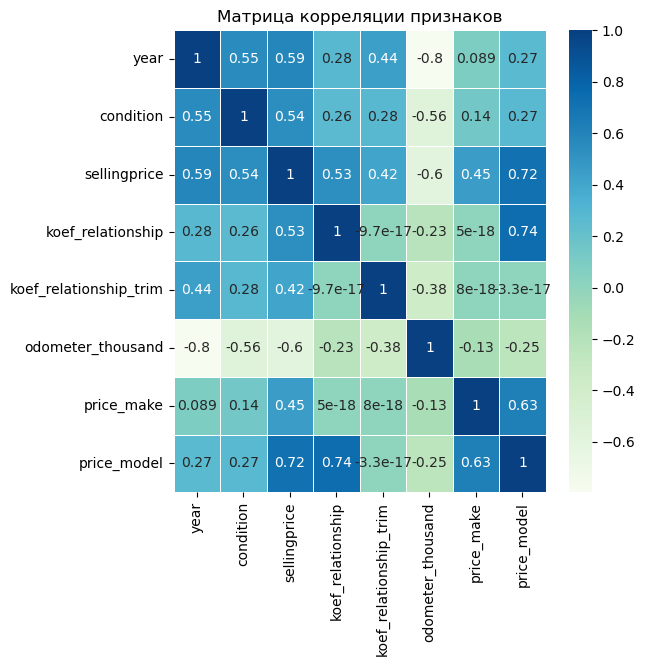

In [42]:
f, ax = plt.subplots(figsize=(6,6))
g = sns.heatmap(df[show_columns].corr(), annot=True, linewidths=.5, ax=ax, cmap = 'GnBu')
plt.title('Матрица корреляции признаков')
plt.show()

Посмотрим еще на нелинейные зависимости. Здесь на передний план вышли - цена за бренд и коэффициент соотношения цены модели и серии.

interval columns not set, guessing: ['year', 'condition', 'sellingprice', 'koef_relationship', 'koef_relationship_trim', 'odometer_thousand', 'price_make', 'price_model']


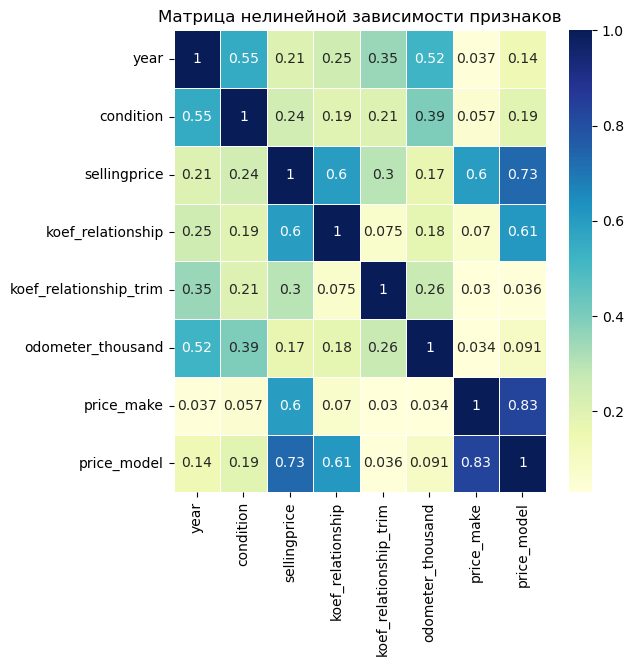

In [43]:
f, ax = plt.subplots(figsize=(6,6))
g = sns.heatmap(df[show_columns].phik_matrix(), annot=True, linewidths=.5, ax=ax, cmap = 'YlGnBu')
plt.title('Матрица нелинейной зависимости признаков')
plt.show()

Добавим новых признаков и заменим где нужно пропуски средними в категории значениями:

 - возраст авто
 - пробег в год
 - оценочный показатель, агрегирующий данные о кондиции и возрасте авто
 - соотношения коэффициента серии изделий и возраста
 - соотношение средней цены на 1 балл кондиции

In [44]:
def preprocessing(df):
    df['age'] = np.where(df['year_sale']-df['year']<0,0,df['year_sale']-df['year'])
    for age in df.loc[df['condition'].isna()]['age'].unique():
        mean_condition = df.loc[(df['condition'].notna())&(df['age']==age)]['condition'].mean()
        df.loc[(df['condition'].isna())&(df['age']==age), 'condition'] = mean_condition
    for age in df.loc[df['odometer_thousand'].isna()]['age'].unique():
        mean_odometer = df.loc[(df['odometer_thousand'].notna())&(df['age']==age)]['odometer_thousand'].mean()
        df.loc[(df['odometer_thousand'].isna())&(df['age']==age), 'odometer_thousand'] = mean_odometer
    df['odometer_thousand_in_year'] = np.where(df['age']==0, df['odometer_thousand'], \
                                                  df['odometer_thousand']/df['age'])
    df['condition_in_year'] = np.where(df['age']==0, df['condition']**2/1, df['condition']**2/df['age'])
    df['condition_odometer'] = df['odometer_thousand']/df['condition']
    df['koef_trim_for_age'] = df['koef_relationship_trim']*df['age']
    df['price_unit_cond'] = df['price_model']/df['condition']
    
preprocessing(df)
preprocessing(test)

Посмотрим еще раз признаки.

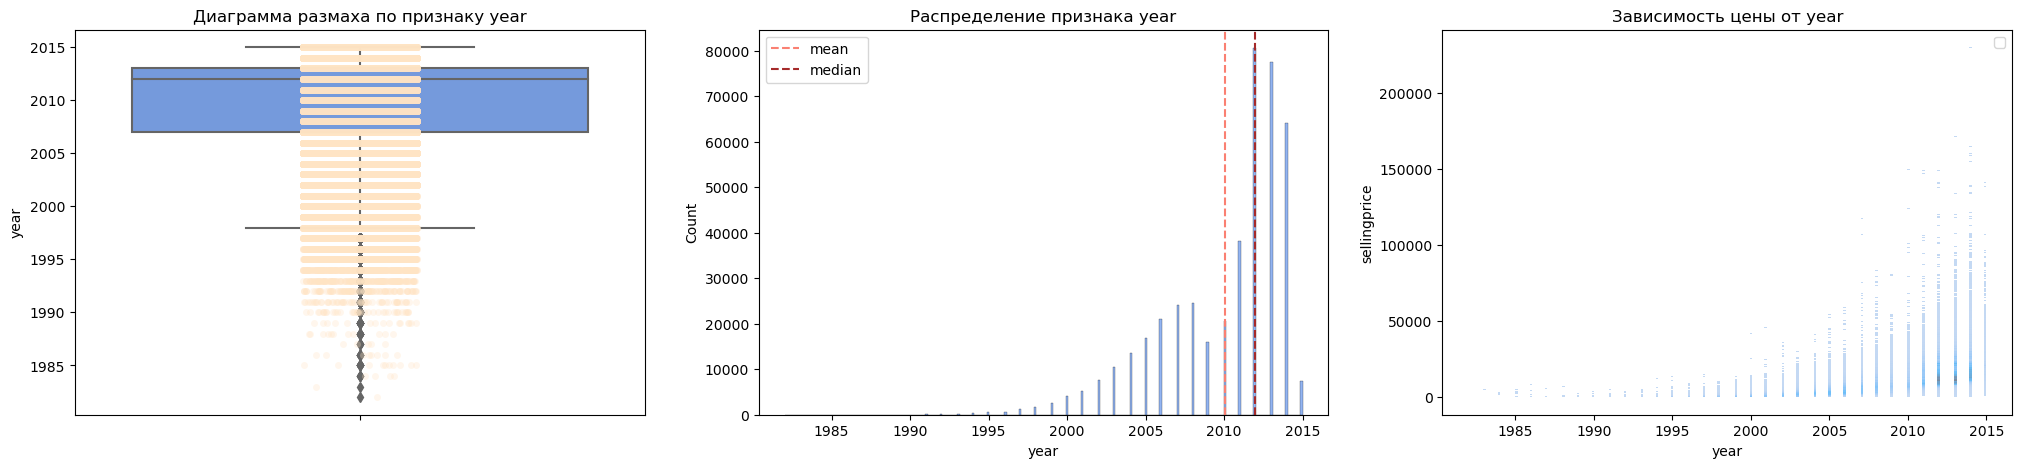

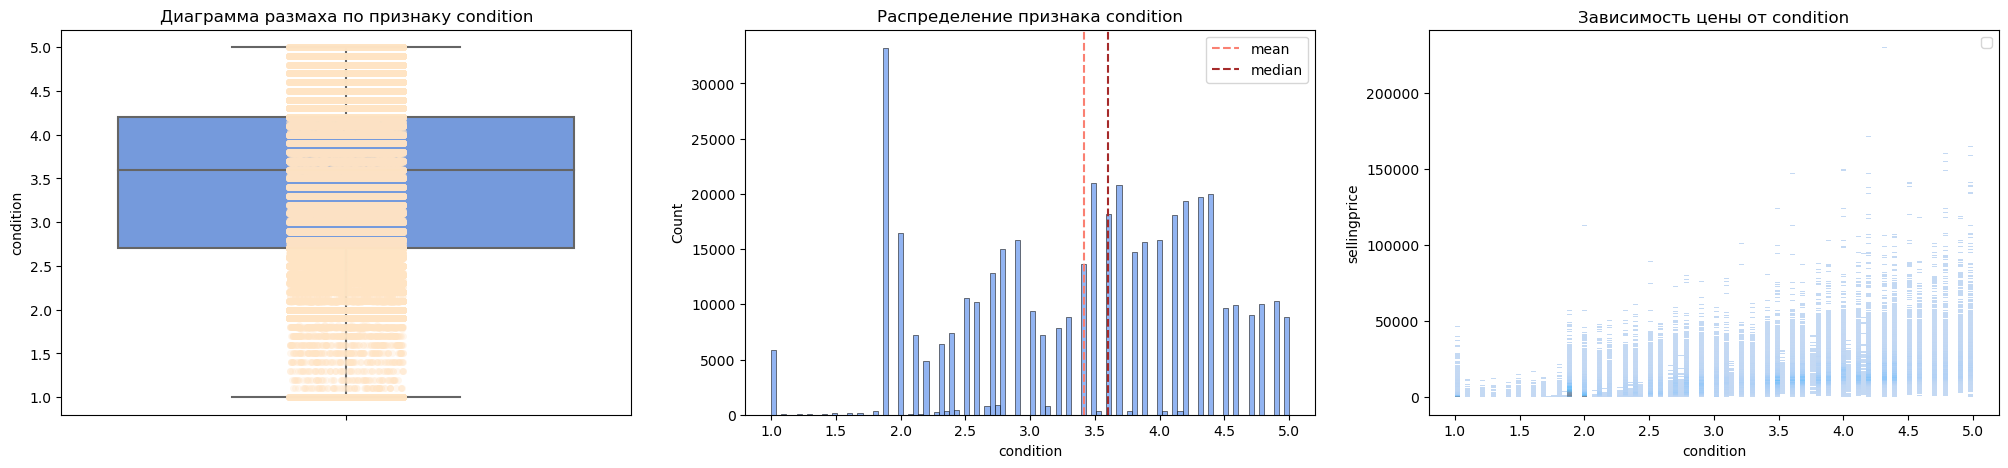

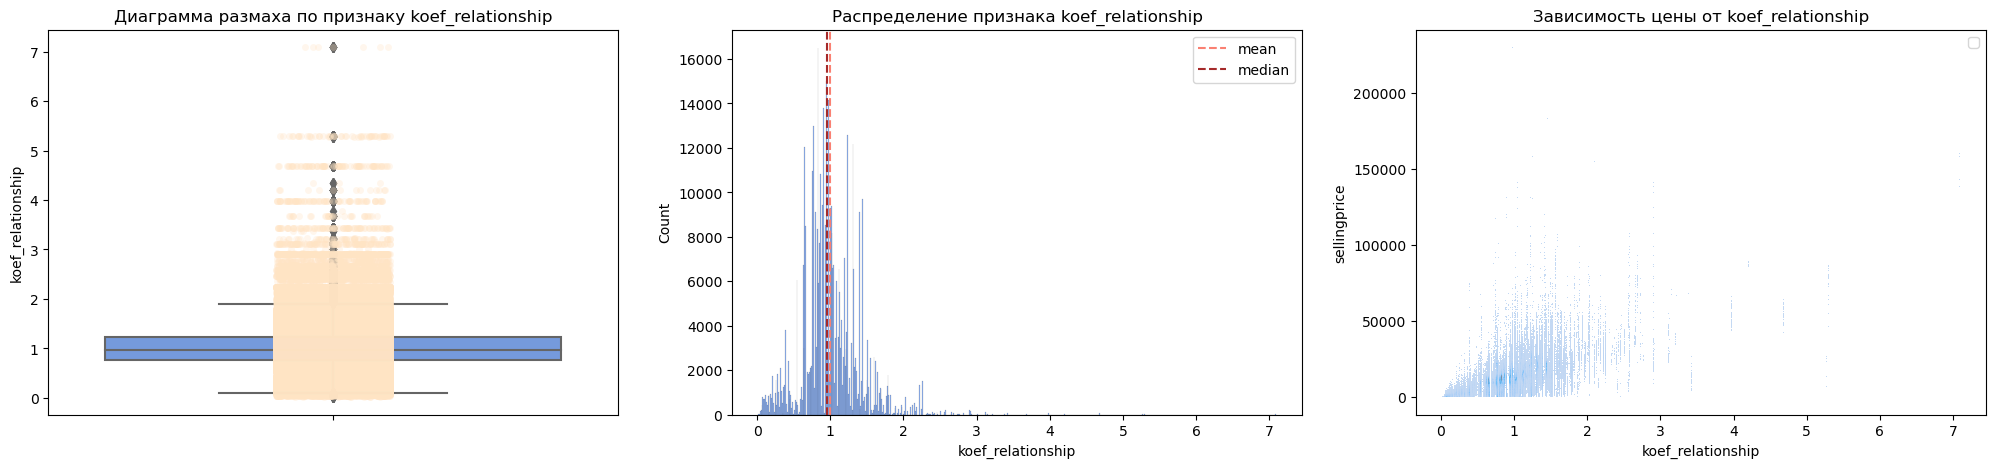

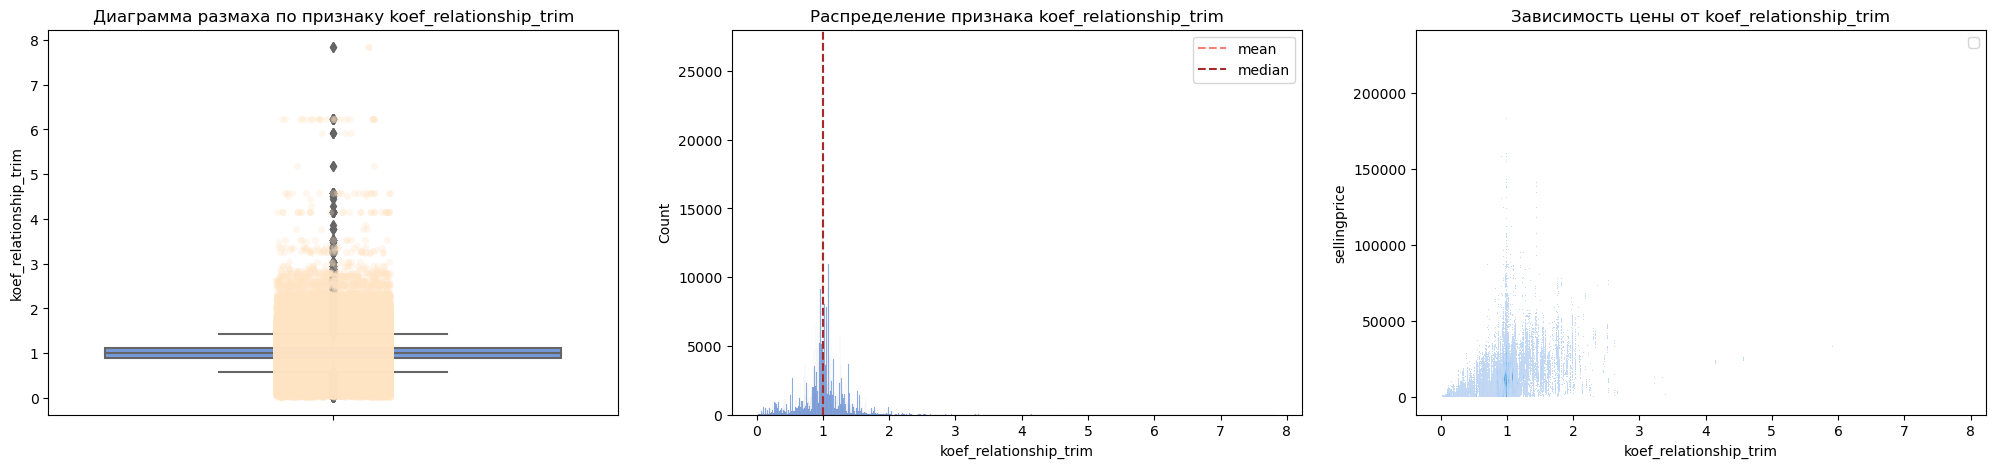

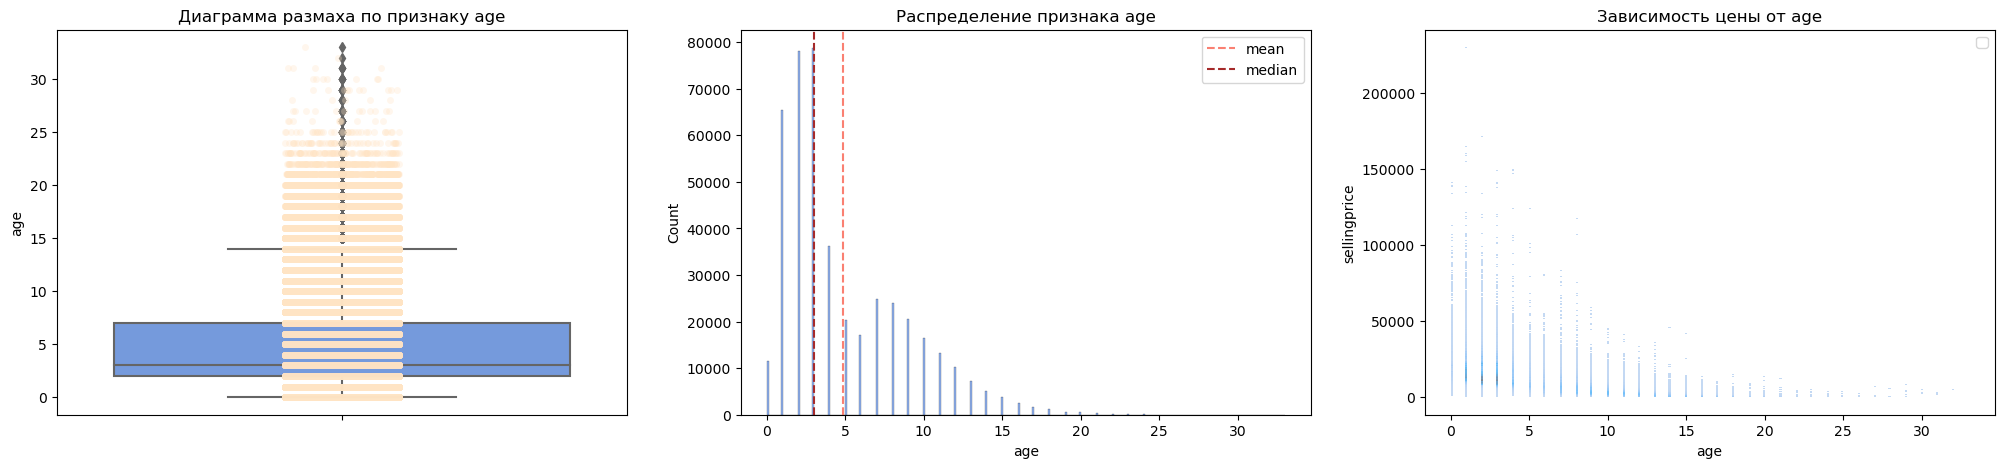

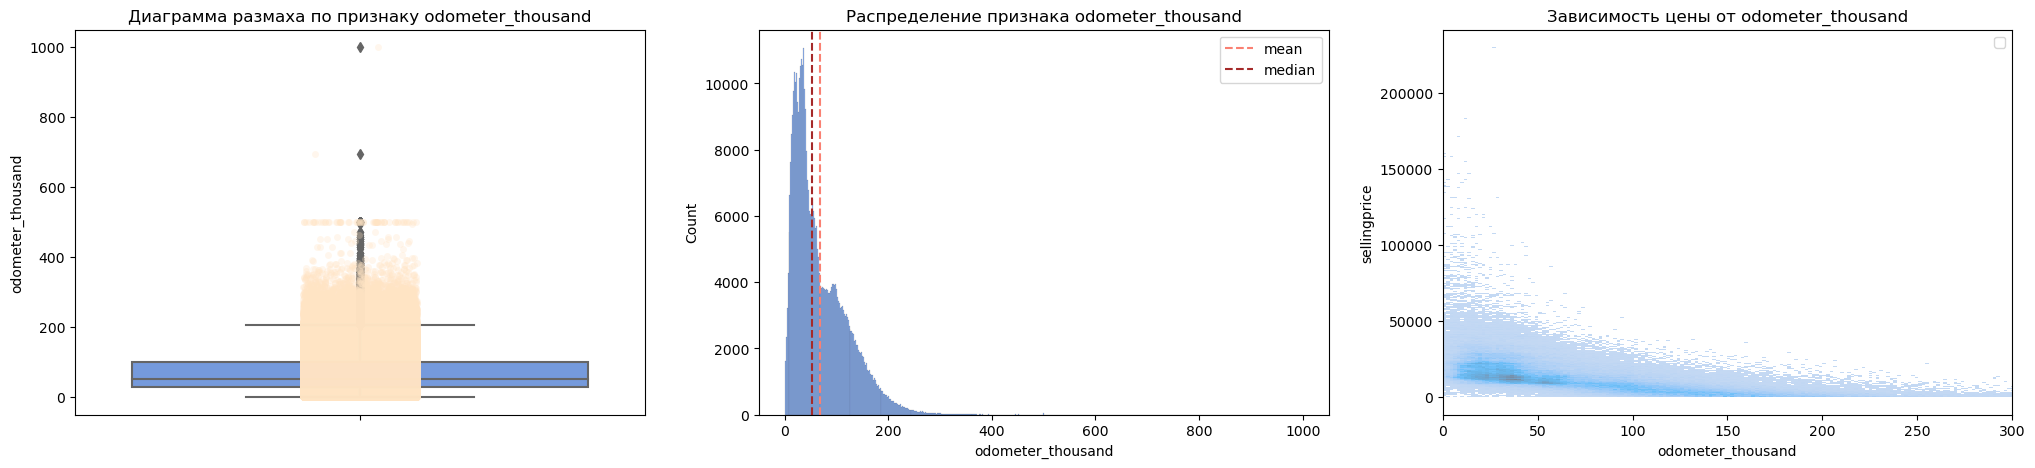

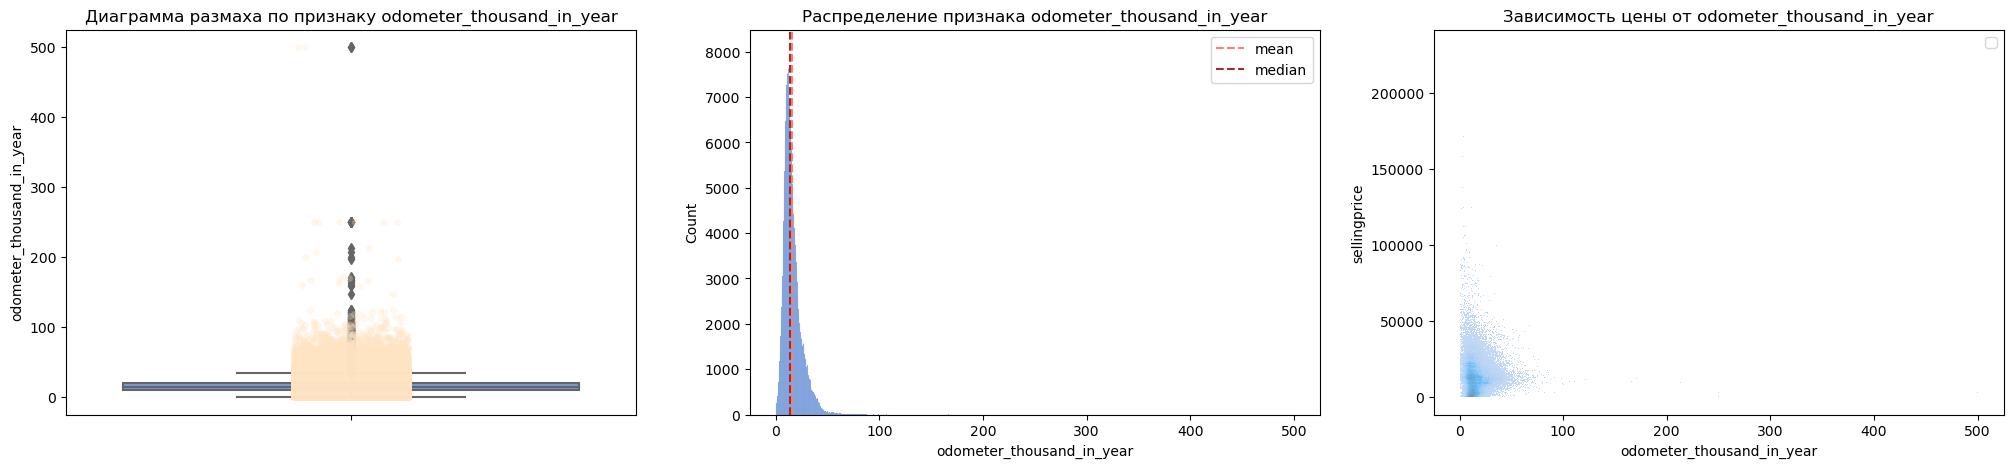

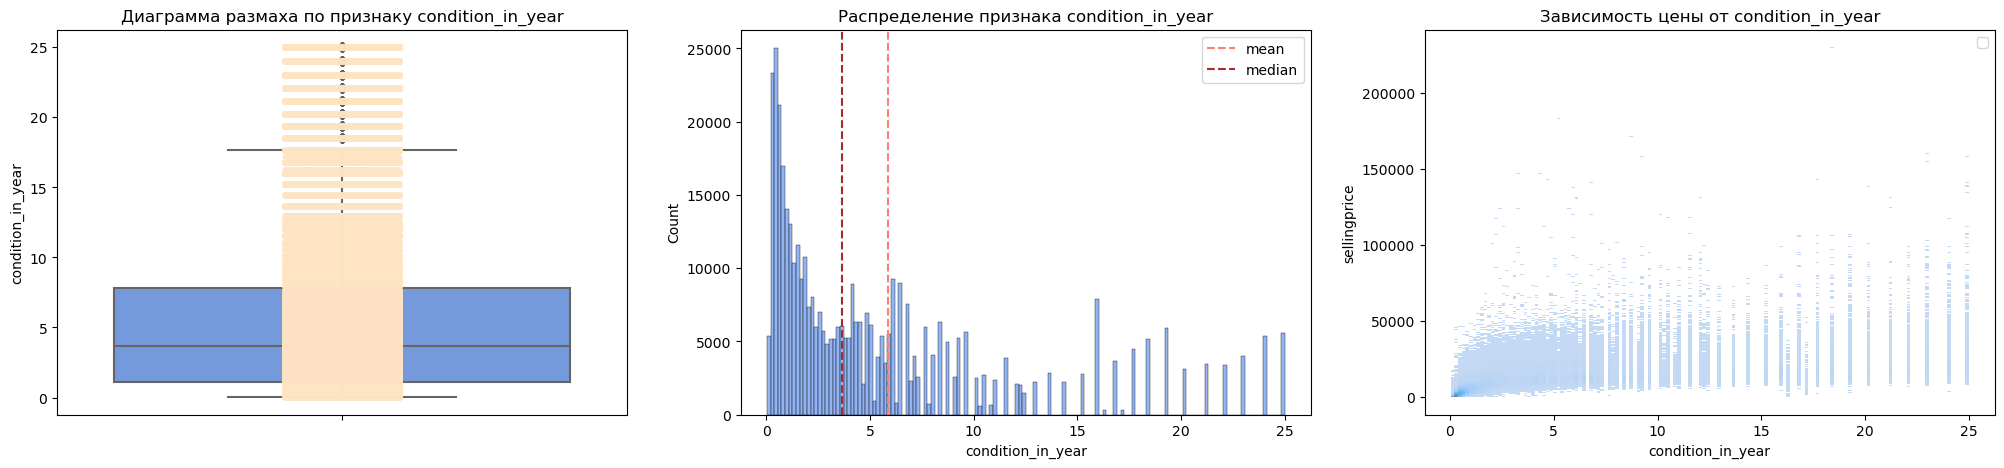

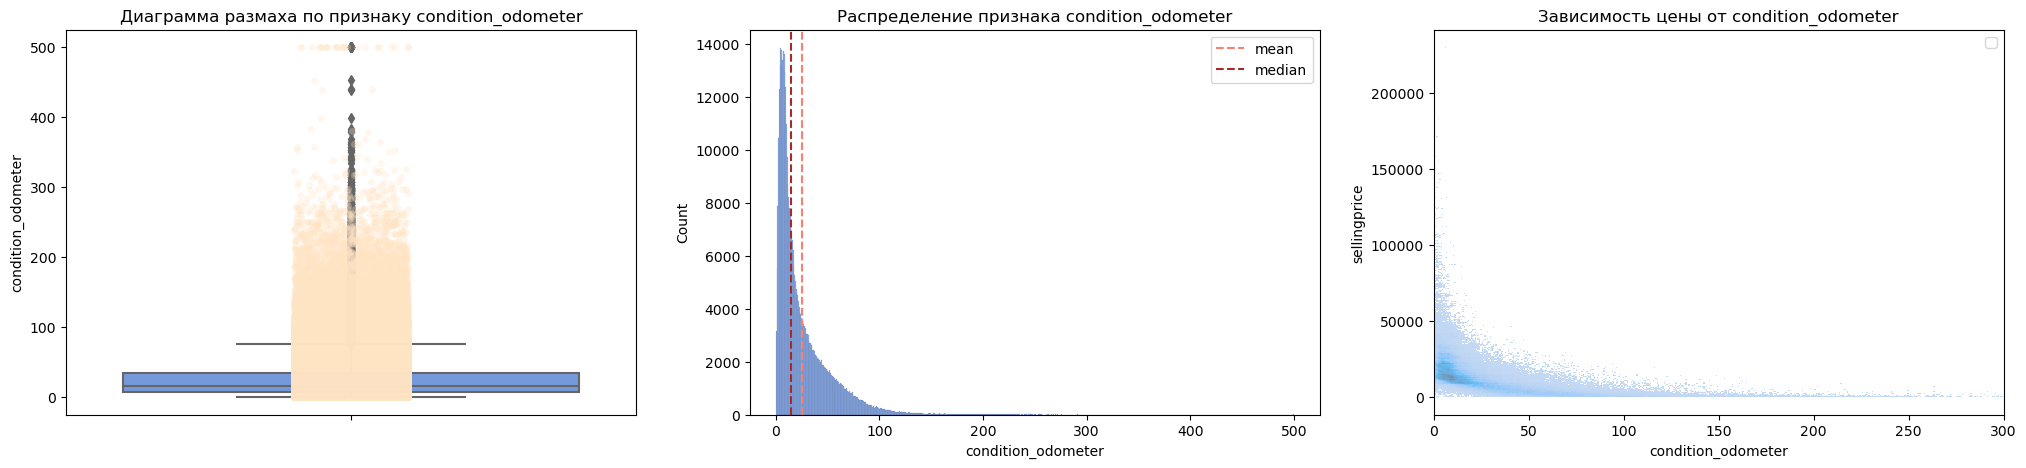

In [45]:
for column in ['year', 'condition', 'koef_relationship', 'koef_relationship_trim',
       'age', 'odometer_thousand', 'odometer_thousand_in_year',
       'condition_in_year', 'condition_odometer']:
    if column in ['odometer_thousand', 'condition_odometer']:
        show_base_info_numerical_columns(df, column, 'o')
    else:
        show_base_info_numerical_columns(df, column)

Для полноты информации нам не хватает еще доли продаж каждой модели в структуре продаж по бренду. Оценим в количественном и стоимостном выражении.

In [46]:
dff = df.groupby(by=['make', 'model'])['sellingprice'].agg(['count', 'sum']).reset_index().rename(columns = {'count':'count_model', 'sum': 'sum_model'})
dff = dff.merge(df.groupby(by=['make'])['sellingprice'].agg(['count', 'sum']).reset_index().rename(columns = {'count':'count_make', 'sum': 'sum_make'}),
               on = ['make'], how = 'left')
dff['share_count_model'] = dff['count_model']/dff['count_make']
dff['share_sum_model'] = dff['sum_model']/dff['sum_make']
df = df.merge(dff[['make', 'model','share_count_model', 'share_sum_model']], on=['make', 'model'], how = 'left')
test = test.merge(dff[['make', 'model','share_count_model', 'share_sum_model']], on=['make', 'model'], how = 'left')

test['share_count_model'] = test['share_count_model'].fillna(1)
test['share_sum_model'] = test['share_sum_model'].fillna(1)

Дополнительно добавим информацию о количестве продаж каждой из моделей бренда в периоде и скользящее среднее по ним.
Получим еще суммарные продажи авто в ценах за единицу кондиции.

In [47]:
def count_sale(df):
    dff = df.groupby(by=['make', 'model','year_sale', 'month'])['make'].agg(['count']).reset_index()
    dff['roling_mean_count'] = np.where((dff['make']==dff['make'].shift(1))&(dff['model']==dff['model'].shift(1)),
                                dff['count'].rolling(2).mean(),dff['count'])
    df = df.merge(dff, on = ['make', 'model','year_sale','month'], how = 'left')
    df['total_sale_in_unit_price'] = df['count']*df['price_unit_cond']
    return df

df = count_sale(df) 
test = count_sale(test)

Отлично, теперь можно посмотреть как часто совершают продажи в разрезе каждого из брендов.

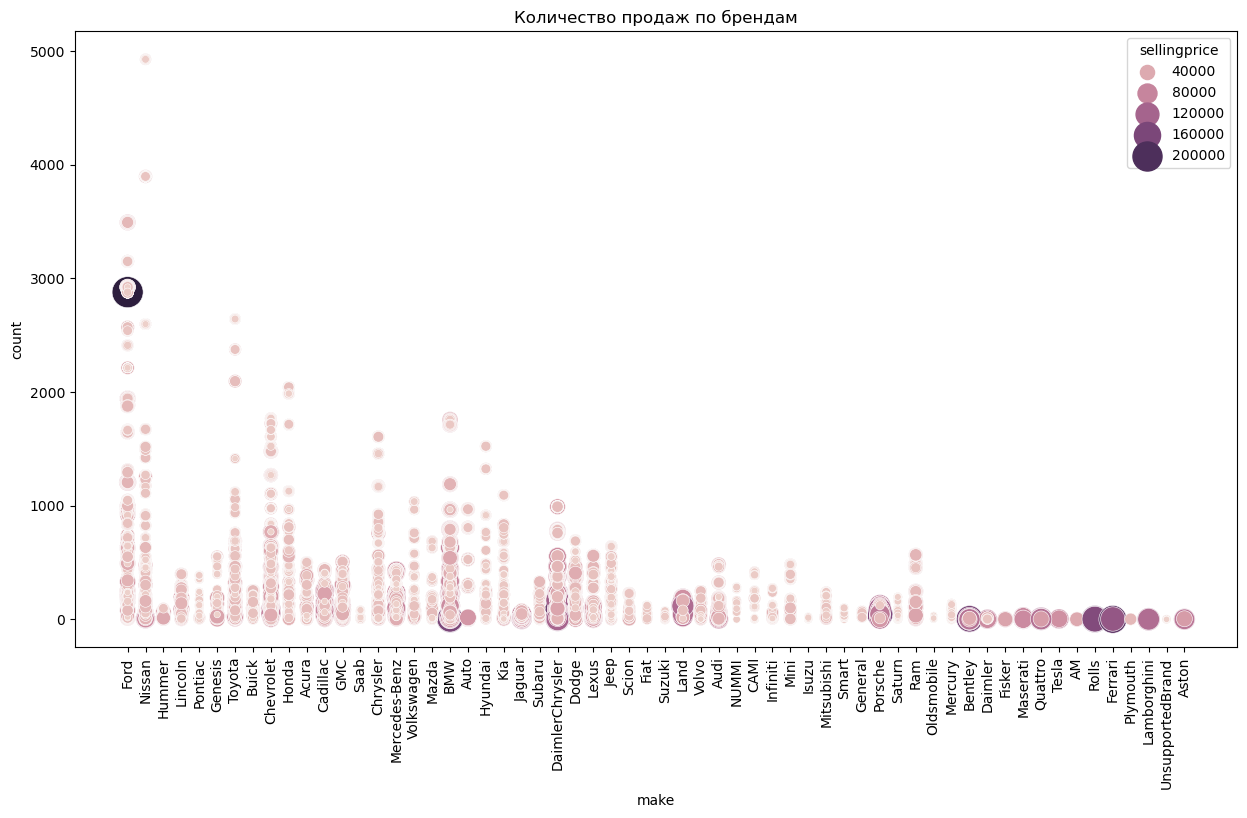

In [48]:
plt.figure(figsize=(15, 8))
plt.title('Количество продаж по брендам')
sns.scatterplot(data=df, y='count', x='make', hue = 'sellingprice',size = 'sellingprice', sizes=(20, 500))
plt.xticks(rotation=90)
plt.show()

Самая популярная из дорогих машин оказалась FORD, по остальным брендам количество продаж дорогих машин мало. Все таки большим спросом пользуются авто со стоимостью до 80000 долларов.

Отберем признаки для обучения и выделим отдельно целевой признак.

In [51]:
drop_columns_all_model = [
    'trim','odometer','model','sellingprice', 'manufacturer', 'model_y', 'trim_y','color', 'interior',
       'body_y','transmission_y','seller', 'year','state', 'saledate','transmission', 
                'country', 'year_sale', 'month', 'weekday',  'saledate_2', 'vds','vis','total_sale_in_unit_price'

]

target = df['sellingprice']

#features_knn = features.copy()
#features_knn = features_knn.drop(drop_columns_all_model, axis = 1)

features_all_model = df.copy()
features_all_model.index = features_all_model.vin
features_all_model = features_all_model.drop(['vin'], axis = 1)
features_all_model = features_all_model.drop(drop_columns_all_model, axis = 1)

In [52]:
features_all_model.columns

Index(['make', 'body', 'condition', 'price_make', 'price_model',
       'koef_relationship', 'koef_relationship_trim', 'odometer_thousand',
       'age', 'odometer_thousand_in_year', 'condition_in_year',
       'condition_odometer', 'koef_trim_for_age', 'price_unit_cond',
       'share_count_model', 'share_sum_model', 'count', 'roling_mean_count'],
      dtype='object')

In [ ]:
#Поделим с помощью KMeans нашу выборку на группы из 5, 15  и 30 кластеров. И добавим полученные классы как признак.

In [ ]:
#features_knn = pd.get_dummies(features_knn, columns = features_knn.select_dtypes(include=['object']).columns, drop_first = True)

In [ ]:
#for i, n_clusters in enumerate([]):
    #knn = KMeans(n_clusters=n_clusters, random_state=12345, n_init='auto')
    #knn.fit(features_, target)
    #features[f'n_clusters_{i}'] = knn.predict(features_)

In [ ]:
#features.head(2)

## Обучение моделей

Так как, предварительно все выбросы в тестовой и обучающей выборке были обработаны, и в основные продажи авто не имеют большого разброса цен, в качестве функции потерь и метрики выберем RMSE. Расчет MAPE в процессе обучения будет в качестве показателя оценки эффективности модели для бустинга.

In [53]:
list_metrics = []

def show_metric(model, X, y):
    prediction = model.predict(X)
    mape = mean_absolute_percentage_error(y,prediction)
    rmse = mean_squared_error(y, prediction, squared=False)
    if model.__class__.__name__=='Pipeline':
        list_metrics.append([model.get_params()['steps'][-1][-1].__class__.__name__, mape, rmse])
    else:
        list_metrics.append([model.__class__.__name__, mape, rmse])

Разделим признаки на категориальные и числовые. Для Случайного Леса и Линейной регрессии потребуется кодирование категорий.

In [54]:
cat_features = features_all_model.select_dtypes(include=['object']).columns
num_features = features_all_model.select_dtypes(include=['int64', 'float64']).columns
features_all_model = pd.get_dummies(features_all_model, columns = cat_features, drop_first = True)

In [55]:
features_train, features_test, target_train, target_test = train_test_split(
    features_all_model, target, test_size = 0.25, random_state = 12345)

### LinearRegression

Начнем с LinearRegression.

In [56]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
    ]
)
params = {'model__fit_intercept': [True, False]}
lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', LinearRegression()),
])
    
grid_search = GridSearchCV(estimator=lr, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, refit=True)

lr_gr = grid_search.fit(features_train, target_train)
print(lr_gr.best_estimator_['model'])

LinearRegression()


In [57]:
lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', lr_gr.best_estimator_['model']),
])
lr.fit(features_train, target_train)
show_metric(lr, features_test, target_test)
print(list_metrics[-1])

['LinearRegression', 0.45492977450883754, 4093.1734358333424]


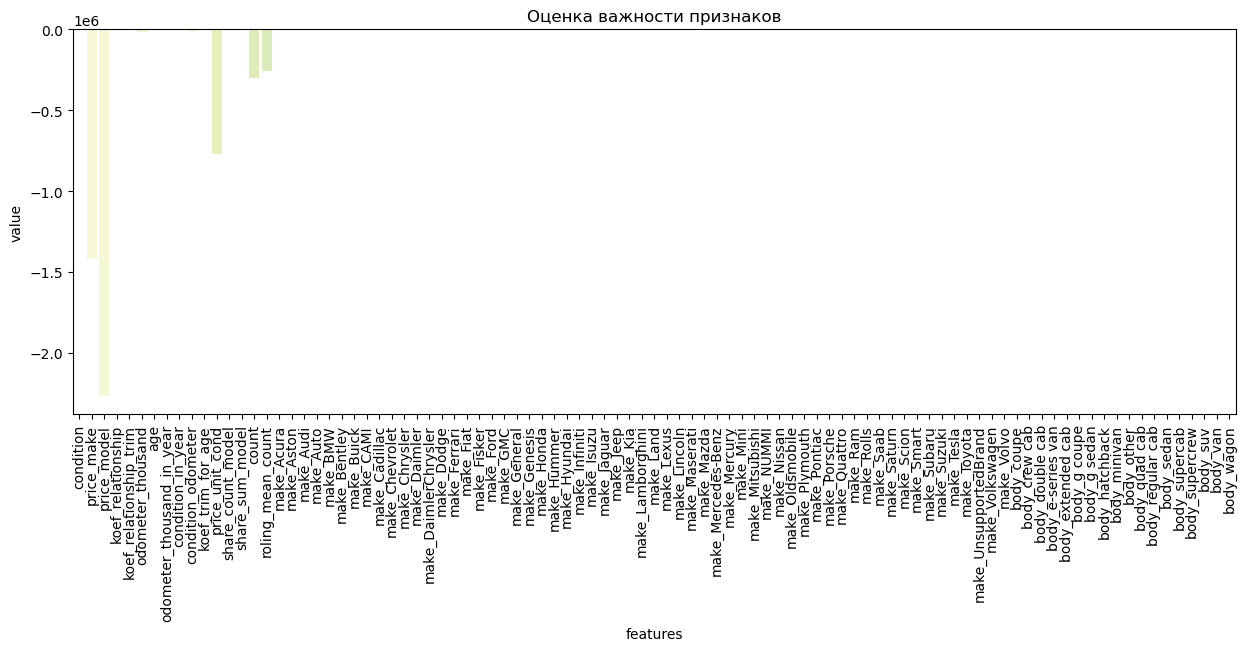

In [58]:
importance = np.std(features_train, 0)*lr.get_params()['steps'][-1][-1].coef_[0]
f, ax = plt.subplots(figsize=(15, 5))
frame = pd.DataFrame([list(features_train.columns), list(importance)]).T.rename(columns = {0: 'features', 1: 'value'})
sns.barplot(data = frame, x = 'features', y = 'value', palette = 'YlGnBu')
plt.xticks(rotation = 90)
#plt.ylim(0, 1500)
plt.title('Оценка важности признаков')
plt.show()

Итак, для модели линейной регрессии наиболее значимыми оказались:

 - средняя цена по обучающей выборке в разрезе бренда
 - средняя цена по обучающей выборке в разрезе модели
 - количество продаж в периоде
 - скользящее среднее по продажам в периоде
 - цена за единицу кондиции
 
 Это не очень информативный набор признаков, поэтому и такие плохие метрики по результатам обучения модели.

### RandomForestRegressor

In [59]:
%%time
params = {
    'model__max_depth': [12,24,48],
    'model__min_samples_split':[2,3]
}
rf = Pipeline(steps=[
    ('model', RandomForestRegressor()),
])
    
grid_search = GridSearchCV(estimator=rf, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, refit=True)

rf_gr = grid_search.fit(features_train, target_train)

CPU times: total: 6min 22s
Wall time: 27min 39s


In [60]:
%%time
rf = Pipeline(steps=[
    ('model', rf_gr.best_estimator_['model']),
])
rf.fit(features_train, target_train)
show_metric(rf, features_test, target_test)
print(list_metrics[-1])

['RandomForestRegressor', 0.1867928773692566, 1898.0563949843672]
CPU times: total: 6min 16s
Wall time: 6min 16s


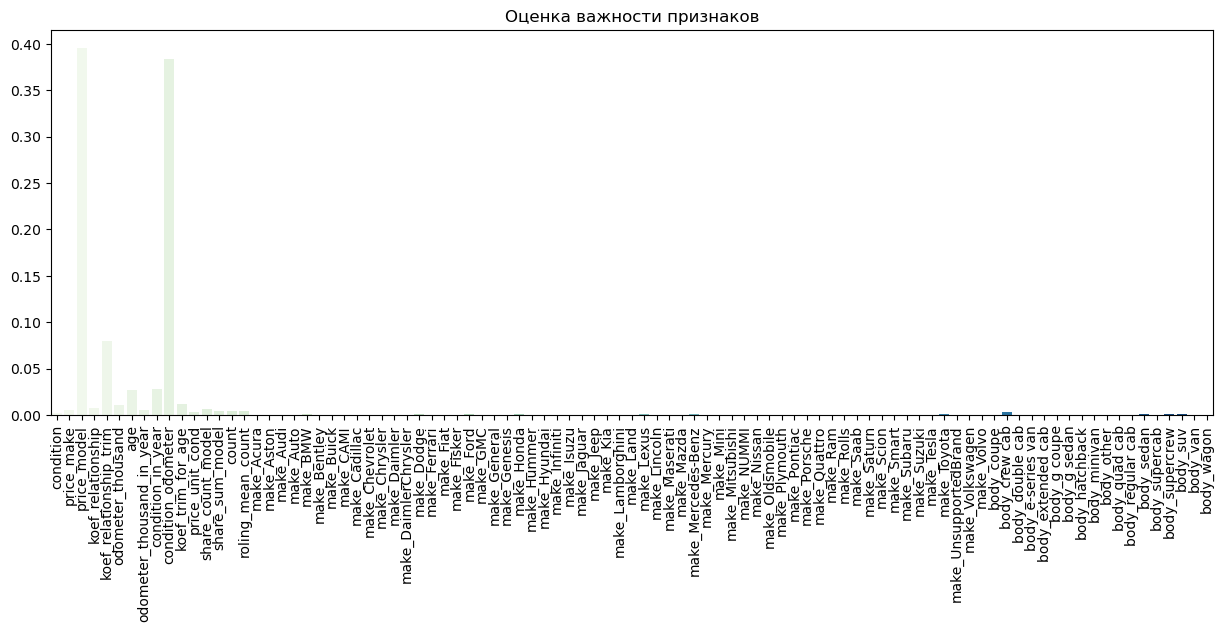

In [61]:
importances = rf_gr.best_estimator_['model'].feature_importances_
plt.figure(figsize=(15,5))
sns.barplot(x =features_train.columns,  y=importances,  palette='GnBu')
plt.title('Оценка важности признаков')
plt.xticks(rotation=90)
plt.show()

Для случайного леса получились вполне приемлемые значения метрик (MAPE около 19%), что говорит о умении модели предсказывать.
Самыми значимыми признаками в обучении оказались:

 - средняя цена по обучающей выборке в разрезе модели
 - коэффициент соотношения средней цены модели и серии
 - оценочный показатель, агрегирующий данные о кондиции и возрасте авто
 - соотношения коэффициента серии изделий и возраста
 - возраст авто

### CatBoostRegressor

In [62]:
drop_columns = ['trim','odometer','model', 'manufacturer', 'model_y', 'trim_y','price_make','koef_relationship', 
       'body_y','transmission_y','seller', 'year','state', 'saledate','interior', 'koef_trim_for_age', 'count','sellingprice', 
                'country', 'year_sale', 'month', 'weekday','condition_in_year','color', 'transmission', 'total_sale_in_unit_price',
       'condition_odometer',  'odometer_thousand_in_year', 'roling_mean_count', 'share_count_model','price_unit_cond',]

features = df.copy()
features.index = features.vin
features = features.drop(['vin'], axis = 1)
features = features.drop(drop_columns, axis = 1)

In [63]:
features.columns

Index(['make', 'body', 'condition', 'vds', 'vis', 'saledate_2', 'price_model',
       'koef_relationship_trim', 'odometer_thousand', 'age',
       'share_sum_model'],
      dtype='object')

In [64]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)

categorial_features = features_train.select_dtypes(include=['object']).columns
cat_features_num = [features_train.columns.get_loc(elem) for elem in categorial_features]

pool = Pool(features_train, target_train, cat_features=cat_features_num)

In [135]:
model = CatBoostRegressor(random_seed = 12345, 
                           eval_metric='MAPE',
                           metric_period=1000,
                           cat_features = cat_features_num,)
param_grid = {
    'learning_rate': [0.2, 0.25, 0.3], 
    'max_depth': [6,7],
    'l2_leaf_reg': [0.01, 0.1, 1, 10],
}
 
search_result = model.grid_search(param_grid, pool, cv = 3, refit=True,  plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7674084	test: 0.7630966	best: 0.7630966 (0)	total: 105ms	remaining: 1m 44s
999:	learn: 0.1847501	test: 0.1573598	best: 0.1573598 (999)	total: 1m 52s	remaining: 0us

bestTest = 0.1573598161
bestIteration = 999

0:	loss: 0.1573598	best: 0.1573598 (0)	total: 1m 52s	remaining: 43m 13s
0:	learn: 0.7236143	test: 0.7180247	best: 0.7180247 (0)	total: 97.5ms	remaining: 1m 37s
999:	learn: 0.1850500	test: 0.1565424	best: 0.1565424 (999)	total: 1m 58s	remaining: 0us

bestTest = 0.1565424402
bestIteration = 999

1:	loss: 0.1565424	best: 0.1565424 (1)	total: 3m 51s	remaining: 42m 28s
0:	learn: 0.6838724	test: 0.6769301	best: 0.6769301 (0)	total: 92.3ms	remaining: 1m 32s
999:	learn: 0.1859464	test: 0.1549458	best: 0.1549458 (999)	total: 1m 56s	remaining: 0us

bestTest = 0.1549457652
bestIteration = 999

2:	loss: 0.1549458	best: 0.1549458 (2)	total: 5m 48s	remaining: 40m 37s
0:	learn: 0.7674109	test: 0.7630991	best: 0.7630991 (0)	total: 104ms	remaining: 1m 44s
999:	learn: 0.1867544	test: 0

In [136]:
search_result

{'params': {'depth': 7, 'learning_rate': 0.3, 'l2_leaf_reg': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0, 999],
              'test-MAPE-mean': [0.6926062465410814, 0.1765964244637853],
              'test-MAPE-std': [0.006549566131604704, 0.03840164124822477],
              'train-MAPE-mean': [0.6941726116751229, 0.16336098695274878],
              'train-MAPE-std': [0.012075678815397905, 0.0161000781115809],
              'test-RMSE-mean': [12236.537475111536, 1847.2484082620413],
              'test-RMSE-std': [23.244535410710213, 41.98151865414882],
              'train-RMSE-mean': [12238.580754872024, 1498.885814561422],
              'train-RMSE-std': [24.24817707094839, 26.428951259704952]})}

In [65]:
model = CatBoostRegressor(iterations=2500,
                          early_stopping_rounds=100,
                          depth=7,
                          loss_function='RMSE',
                          cat_features = cat_features_num,
                          random_state=12345,
                          l2_leaf_reg = 0.01,
                          learning_rate = 0.3,
                          verbose = 10,
                          eval_metric='MAPE'
                          )
model.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
show_metric(model, features_test, target_test)
list_metrics[-1]

['CatBoostRegressor', 0.17773745552084574, 1729.9962849099893]

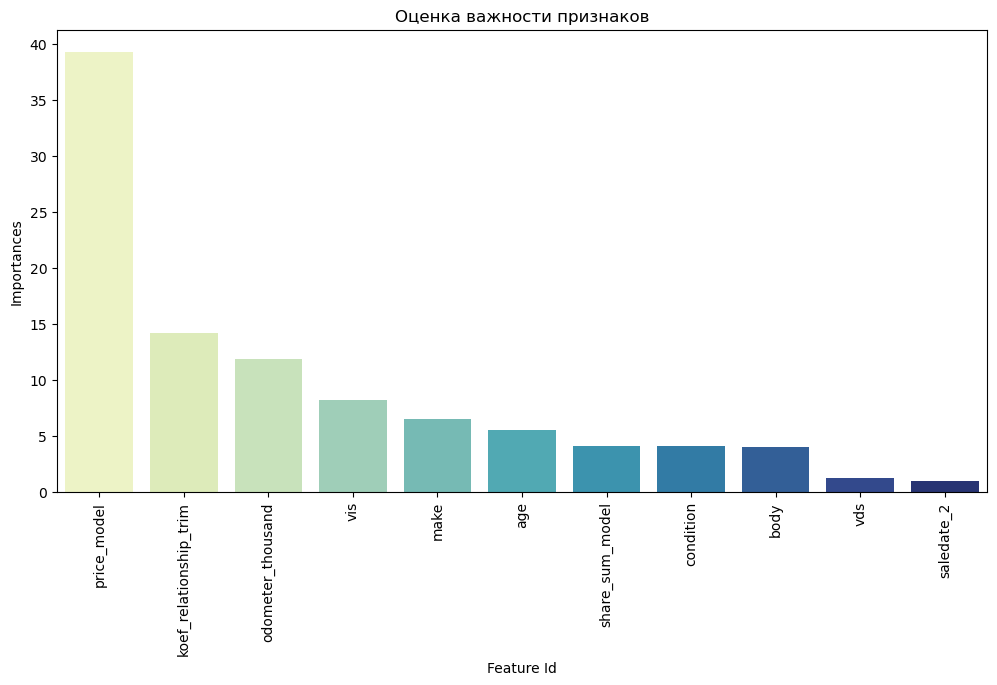

In [67]:
importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12,6))
sns.barplot(x ='Feature Id',  y='Importances', data=importances,  palette='YlGnBu')
plt.xticks(rotation = 90)
plt.title('Оценка важности признаков')
plt.show()

Самых точных прогнозов удалось добиться с помощью бустинга: с использованием этой модели получены минимальные показатели и MAPE (до 17% на валидации и 15% на тестовой выборке) и RMSE (до 1700).
Наиболее значимыми в процессе обучения оказались:

 - средняя цена по обучающей выборке в разрезе модели
 - коэффициент соотношения средней цены модели и серии
 - пробег в тысячах
 - vis и бренд

### Submit

In [68]:
drop_columns = ['trim','odometer','model', 'manufacturer', 'model_y', 'trim_y','price_make','koef_relationship', 
       'body_y','transmission_y','seller', 'year','state', 'saledate','interior', 'koef_trim_for_age', 'count',
                'country', 'year_sale', 'month', 'weekday','condition_in_year','color', 'transmission', 'total_sale_in_unit_price',
       'condition_odometer',  'odometer_thousand_in_year', 'roling_mean_count', 'share_count_model','price_unit_cond',]

tt = test.drop(drop_columns, axis = 1)
tt.index = tt.vin
tt = tt.drop(['vin'], axis = 1)

In [69]:
prediction = model.predict(tt)

In [70]:
result = pd.DataFrame(prediction, index = tt.index).rename(columns = {0:'sellingprice'})
result

,sellingprice
vin,
1g6dp567450124779,4375.810740
1gtw7fca7e1902207,21738.123515
jn8az1mw6dw303497,18837.103377
2g1wf5e34d1160703,8951.678122
1n6aa0ec3dn301209,22209.503505
...,...
1j4aa2d17bl584330,15913.731933
jthbf1d23e5007526,29007.760993
1n4ba41e54c831950,3879.430185


In [71]:
result.to_csv('C:/Users/user/Desktop/out_catboost.csv', index=True)

## Выводы

Задачей данного проекта является предсказание стоимости подержанного автомобиля на вторичном рынке.

В процессе подготовки данных к обучению были сделаны следующие наблюдения:

 - Лидерами продаж среди брендов являются товары морок Форд, Ниссан, Тойота, Шевроле, Киа. Тогда как самые дорогие продажи были совершены по брендам Бентли, Роллс-ройс, Феррари. Средняя цена продажи 12 тыс. долларов.
 - Цена зависит и от типа кузова. Наиболее популярны седаны.
 - Машины с автоматической коробкой передач продаются чаще.
 - Разбос цен по нестандартным цветам отделки машины выше. Базовые цвета идут примерно с одинаковой стоимостью, большинство машин продается в стандартных цветах. 
 - В основном продаются относительно новые авто. Средний возраст продаваемых машин 5 лет, медианный - 3 года. Это в принципе логично, т.к. при таких показателях можно продать машину по хорошей цене.
 - Основные продажи приходятся на машины с кондиционным показателям от 3,5 до 4,5, а также 1,9-2. Для последней группы максимальная цена продажи не превышает порог в 50000 долларов. Чем выше показатель кондиции, тем дороже можно продать авто.
 - Большая часть автомобилей имеет пробег до 150 тыс. км. 

Резюмируя предварительный анализ бал выдвинута гипотеза, что самыми значимыми признаками для определения стоимости будут являться: кондиция, пробег, возраст и информация о бренде, модели и серии.  Эти данные должны быть обязательно представлены в обучающей выборке.

Так как, предварительно все выбросы в тестовой и обучающей выборке были обработаны, и в основные продажи авто не имеют большого разброса цен, в качестве функции потерь была выбрана RMSE. В качетсве метрики использовалась MAPE.


In [72]:
pd.DataFrame(list_metrics, columns = ['model', 'mape', 'rmse'])

,model,mape,rmse
0,LinearRegression,0.454930,4093.173436
1,RandomForestRegressor,0.186793,1898.056395
2,CatBoostRegressor,0.177737,1729.996285


Было обучено 3 модели: Линейная регрессия, Случайный лес и бустинг.

**Линейная регрессия**

Как видно из таблицы выше использование данной модели оказалось не очень эффективным. Это связано с неподходящим набором признаков, которые мы "скормили" модели. Посмотрим, какие фичи оказались наиболоее важными:

 - средняя цена по обучающей выборке в разрезе бренда
 - средняя цена по обучающей выборке в разрезе модели
 - количество продаж в периоде
 - скользящее среднее по продажам в периоде
 - цена за единицу кондиции
 
 Да, первые два признака действительно целесообразно использовать для обучения, тогда как остальные привносят скорее деструктивный вклад, так как не имеют даже слабовыраженной корреляции между другими признаками и таргетом. Но, как показали эксперименты с бустингом, могут чуть-чуть улучшить скор, если для модели набор значимых признаков другой.

**Случайный лес**

Здесь мы получили хороший результат и набор значимых признаков, который подтвердил нашу гипотезу:


 - средняя цена по обучающей выборке в разрезе модели
 - коэффициент соотношения средней цены модели и серии
 - оценочный показатель, агрегирующий данные о кондиции и возрасте авто
 - соотношения коэффициента серии изделий и возраста
 - возраст авто
 
 **Бустинг**
 
 Самых точных прогнозов удалось добиться с помощью бустинга: с использованием этой модели получены минимальные показатели и MAPE (до 17% на валидации и 15% на тестовой выборке) и RMSE (до 1700).
Наиболее значимыми в процессе обучения оказались:

 - средняя цена по обучающей выборке в разрезе модели
 - коэффициент соотношения средней цены модели и серии
 - пробег в тысячах
 - vis и бренд
 
 Следует отметить, что использование в признаках данных о продавце значительно улучшает скор (можно на сабмите уменьшить до 14%). 